# Test validity step 1 : $P(\eta | ...) \propto \eta^t \left( C_{approx}^{1/2} (C_{approx}^{-1} + (E^t (B^t N^{-1} B)^{-1} E)^{-1}) C_{approx}^{1/2} \right)^{-1} \eta$

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import astropy.io.fits as fits
import scipy
import camb
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax_healpy as jhp
import jax.lax as jlx
import jaxopt as jopt

import micmac as micmac

In [2]:
sys.path.append(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('')))+'/tutorials/')
# from func_tools_for_tests import *
from get_freq_maps_SO_64 import *
# from get_freq_maps_SO_64_lower_noise import *
# from get_freq_maps_LiteBIRD_64 import *
# freq_maps is defined there

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Shape for input frequency maps : (6, 2, 49152)
Shape for input cmb maps : (6, 2, 49152)


In [3]:
instrument

frequency  depth_p  depth_i  fwhm  f_sky    status  \
0       27.0     49.5     35.0  91.0    0.1  forecast   
1       39.0     29.7     21.0  63.0    0.1  forecast   
2       93.0      3.7      2.6  30.0    0.1  forecast   
3      145.0      4.7      3.3  17.0    0.1  forecast   
4      225.0      8.9      6.3  11.0    0.1  forecast   
5      280.0     22.6     16.0   9.0    0.1  forecast   

                                           reference    type  \
0  Journal of Cosmology and Astroparticle Physics...  ground   
1  Journal of Cosmology and Astroparticle Physics...  ground   
2  Journal of Cosmology and Astroparticle Physics...  ground   
3  Journal of Cosmology and Astroparticle Physics...  ground   
4  Journal of Cosmology and Astroparticle Physics...  ground   
5  Journal of Cosmology and Astroparticle Physics...  ground   

                                  note experiment  
0  depth_p is simply depth_i * sqrt(2)     SO_SAT  
1  depth_p is simply depth_i * sqrt(2)     SO_SAT  
2  depth_p is simply depth_i * sqrt(2)     SO_SAT  
3  depth_p is simply depth_i * sqrt(2)     SO_SAT  
4  depth_p is simply depth_i * sqrt(2)     SO_SAT  
5  depth_p is simply depth_i * sqrt(2)     SO_SAT

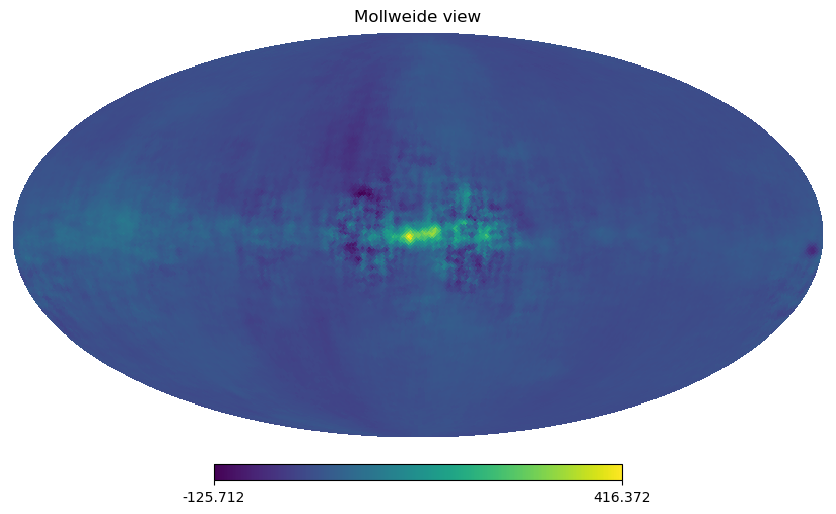

In [4]:
hp.mollview(freq_maps[0,0]) # Freq, nstokes, npix

In [5]:

working_directory_path = '/Users/mag/Documents/PHD1Y/Space_Work/Pixel_non_P2D/MICMAC/test_playground/validation_chain_v5/'
directory_save_file = working_directory_path + 'save_directory/'
directory_toml_file = working_directory_path + 'toml_params/'

# path_toml_file = directory_toml_file + 'biased_full_chain_v1a.toml'
path_toml_file = directory_toml_file + 'biased_full_chain_v1c.toml'

MICMAC_sampler_obj = micmac.create_MICMAC_sampler_from_toml_file(path_toml_file)


In [6]:
path_mask = "/Users/mag/Documents/PHD1Y/Masks/mask_SAT_apodized.fits"

apod_mask = hp.ud_grade(hp.read_map(path_mask),nside_out=MICMAC_sampler_obj.nside)
mask = np.copy(apod_mask)
mask[apod_mask>0] = 1

# mask = np.ones(MICMAC_sampler_obj.npix)

MICMAC_sampler_obj.mask = mask

In [7]:
%%time

freq_inverse_noise = MICMAC_sampler_obj.freq_inverse_noise

freq_inverse_noise_masked = np.zeros((MICMAC_sampler_obj.number_frequencies,MICMAC_sampler_obj.number_frequencies,MICMAC_sampler_obj.npix))

nb_pixels_mask = int(mask.sum())
freq_inverse_noise_masked[:,:,mask!=0] = np.repeat(freq_inverse_noise.ravel(order='F'), nb_pixels_mask).reshape((MICMAC_sampler_obj.number_frequencies,MICMAC_sampler_obj.number_frequencies,nb_pixels_mask), order='C')


CPU times: user 8.73 ms, sys: 1.09 ms, total: 9.82 ms
Wall time: 8.58 ms


In [8]:
MICMAC_sampler_obj.freq_inverse_noise = freq_inverse_noise_masked

In [9]:
MICMAC_sampler_obj.freq_inverse_noise[:,:,mask==0]

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 

In [10]:
input_freq_maps, _, theoretical_red_cov_r0_total, theoretical_red_cov_r1_tensor = MICMAC_sampler_obj.generate_input_freq_maps_from_fgs(freq_maps_fgs, return_only_freq_maps=False)

input_freq_maps_masked = input_freq_maps*mask

# Re-Defining the data if needed
indices_polar = np.array([1,2,4])
partial_indices_polar = indices_polar[:MICMAC_sampler_obj.nstokes]


theoretical_r0_total = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total)#[partial_indices_polar,:]
theoretical_r1_tensor = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r1_tensor)#[partial_indices_polar,:]


c_ell_approx = np.zeros((3,MICMAC_sampler_obj.lmax+1))
c_ell_approx[0,MICMAC_sampler_obj.lmin:] = theoretical_r0_total[0,:]
c_ell_approx[1,MICMAC_sampler_obj.lmin:] = theoretical_r0_total[1,:]

# Params mixing matrix
init_mixing_matrix_obj = micmac.InitMixingMatrix(MICMAC_sampler_obj.frequency_array, MICMAC_sampler_obj.number_components, pos_special_freqs=MICMAC_sampler_obj.pos_special_freqs)
exact_params_mixing_matrix = init_mixing_matrix_obj.init_params()

mixing_matrix_obj = micmac.MixingMatrix(MICMAC_sampler_obj.frequency_array, MICMAC_sampler_obj.number_components, exact_params_mixing_matrix, pos_special_freqs=MICMAC_sampler_obj.pos_special_freqs)

mixing_matrix_sampled = mixing_matrix_obj.get_B()

BtinvNB = micmac.get_inv_BtinvNB(MICMAC_sampler_obj.freq_inverse_noise, mixing_matrix_sampled)
BtinvN_sqrt = micmac.get_BtinvN(np.sqrt(MICMAC_sampler_obj.freq_inverse_noise), mixing_matrix_sampled)

Calculating spectra from CAMB !
Calculating spectra from CAMB !


In [11]:
red_cov_approx_matrix = micmac.get_reduced_matrix_from_c_ell(c_ell_approx)[MICMAC_sampler_obj.lmin:,...]

In [12]:
red_cov_approx_matrix.shape

(127, 2, 2)

In [13]:
lmax = MICMAC_sampler_obj.lmax
n_iter = MICMAC_sampler_obj.n_iter
lmin = MICMAC_sampler_obj.lmin
nstokes = MICMAC_sampler_obj.nstokes
nside = MICMAC_sampler_obj.nside
number_frequencies = MICMAC_sampler_obj.number_frequencies
npix = MICMAC_sampler_obj.npix


In [14]:
# MICMAC_sampler_obj.limit_iter_cg = 200

In [15]:
jax_key_PNRG = jax.random.PRNGKey(MICMAC_sampler_obj.seed+10)
jax_key_PNRG = jax.random.PRNGKey(MICMAC_sampler_obj.seed+20)


In [16]:
%%time

map_random_x = jnp.empty(0)
map_random_y = jnp.empty(0)
eta_maps = MICMAC_sampler_obj.get_sampling_eta_v2(red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, jax_key_PNRG, map_random_x=map_random_x, map_random_y=map_random_y, suppress_low_modes=True)


Recalculating x !
Recalculating y !
CPU times: user 5.37 s, sys: 882 ms, total: 6.25 s
Wall time: 2.38 s


In [17]:
jitted_sampling_eta = jax.jit(MICMAC_sampler_obj.get_sampling_eta_v2, static_argnames=['suppress_low_modes'])

In [18]:
%%time
eta_maps = jitted_sampling_eta(red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, jax_key_PNRG, map_random_x=map_random_x, map_random_y=map_random_y, suppress_low_modes=True)


Recalculating x !
Recalculating y !
CPU times: user 2.01 s, sys: 340 ms, total: 2.35 s
Wall time: 885 ms


In [19]:
%%time
eta_maps = jitted_sampling_eta(red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, jax_key_PNRG, map_random_x=map_random_x, map_random_y=map_random_y, suppress_low_modes=True)


CPU times: user 489 ms, sys: 64.6 ms, total: 554 ms
Wall time: 133 ms


In [20]:
%%time
eta_maps = MICMAC_sampler_obj.get_sampling_eta_v2b(red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, jax_key_PNRG, map_random_x=map_random_x, map_random_y=map_random_y, suppress_low_modes=True)


Recalculating x !
Recalculating y !
CPU times: user 14.5 s, sys: 2.32 s, total: 16.8 s
Wall time: 2.65 s


In [21]:
# %%time
# eta_maps = jitted_sampling_eta(red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, jax_key_PNRG, map_random_x=map_random_x, map_random_y=map_random_y, suppress_low_modes=True)


In [22]:
# %%time
# eta_maps = jitted_sampling_eta(red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, jax_key_PNRG, map_random_x=map_random_x, map_random_y=map_random_y, suppress_low_modes=True)


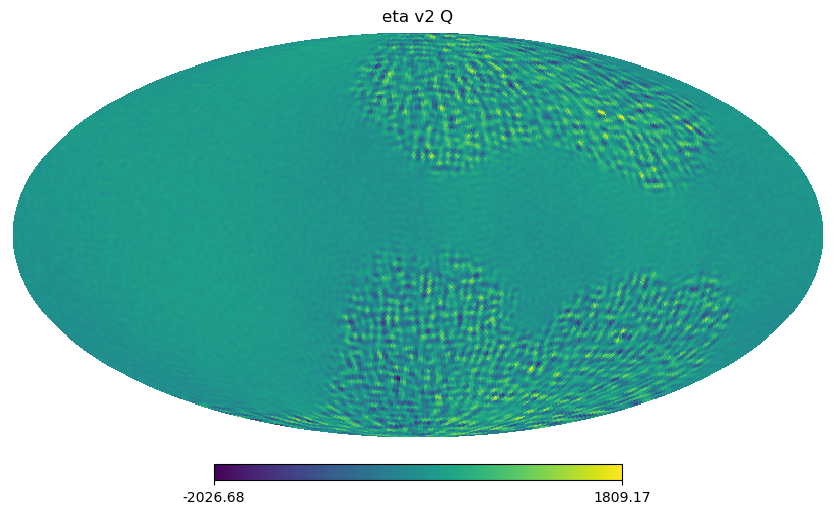

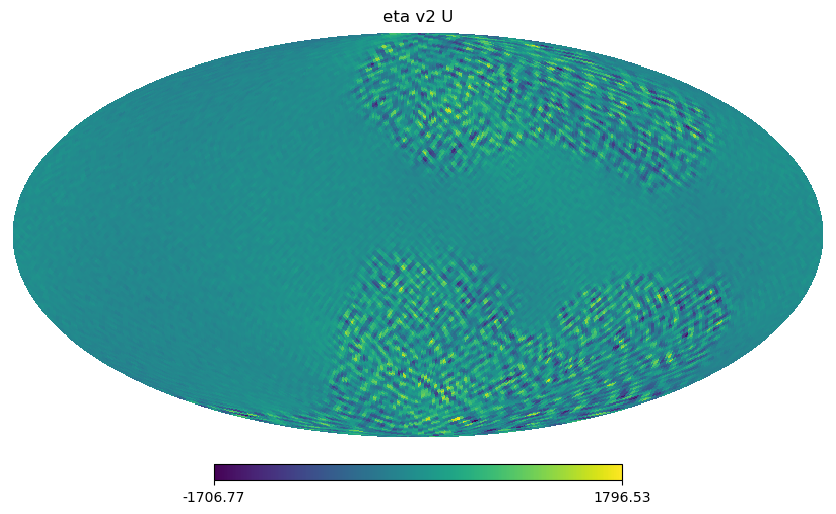

In [23]:
hp.mollview(eta_maps[0], title='eta v2 Q')
hp.mollview(eta_maps[1], title='eta v2 U')

In [24]:
%%time

map_random_x = jnp.empty(0)
map_random_y = jnp.empty(0)
eta_maps_v1 = MICMAC_sampler_obj.get_sampling_eta_v1(red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, jax_key_PNRG, map_random_x=map_random_x, map_random_y=map_random_y, suppress_low_modes=True)

Recalculating x !
Recalculating y !
CPU times: user 1.39 s, sys: 335 ms, total: 1.72 s
Wall time: 306 ms


In [25]:
jitted_sampling_eta_v1 = jax.jit(MICMAC_sampler_obj.get_sampling_eta_v1, static_argnames=['suppress_low_modes'])

In [26]:
%%time

map_random_x = jnp.empty(0)
map_random_y = jnp.empty(0)
eta_maps_v1 = jitted_sampling_eta_v1(red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, jax_key_PNRG, map_random_x=map_random_x, map_random_y=map_random_y, suppress_low_modes=True)

Recalculating x !
Recalculating y !
CPU times: user 976 ms, sys: 113 ms, total: 1.09 s
Wall time: 665 ms


In [27]:
%%time

map_random_x = jnp.empty(0)
map_random_y = jnp.empty(0)
eta_maps_v1 = jitted_sampling_eta_v1(red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, jax_key_PNRG, map_random_x=map_random_x, map_random_y=map_random_y, suppress_low_modes=True)

CPU times: user 229 ms, sys: 42.3 ms, total: 272 ms
Wall time: 43.8 ms


In [28]:
component_eta_map_prime = np.einsum('kcp,cfp,fsp->ksp', BtinvNB, BtinvN_sqrt, eta_maps_v1)[0]*hp.nside2resol(nside)


In [29]:
jax_key_PNRG = jax.random.PRNGKey(MICMAC_sampler_obj.seed+100)
new_eta_maps_v1 = MICMAC_sampler_obj.get_sampling_eta_v1(red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, jax_key_PNRG+1, map_random_x=map_random_x, map_random_y=map_random_y, suppress_low_modes=True)
old_eta_maps_v1 = np.copy(eta_maps_v1)

Recalculating x !
Recalculating y !


In [30]:
eta_maps_extended = np.vstack([np.zeros_like(eta_maps[0]), eta_maps])
c_ells_eta = hp.anafast(eta_maps_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

In [31]:
eta_maps_v1_extended = np.vstack([np.zeros_like(component_eta_map_prime[0]), component_eta_map_prime])
c_ells_eta_v1 = hp.anafast(eta_maps_v1_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

In [32]:
# covariance_noise = np.zeros_like(c_ell_approx)
# # covariance_noise[:nstokes,lmin:] = scipy.linalg.sqrtm(BtinvNB)[0,0]*np.ones_like(c_ell_approx)[:nstokes,lmin:]
# covariance_noise[:nstokes,lmin:] = BtinvNB[0,0]*np.ones_like(c_ell_approx)[:nstokes,lmin:]

_cl_noise_harm = micmac.get_Cl_noise(np.array(instrument['depth_p']), mixing_matrix_sampled, MICMAC_sampler_obj.lmax)[0,0,lmin:]

red_cl_noise_harm = micmac.get_reduced_matrix_from_c_ell(np.array([_cl_noise_harm,_cl_noise_harm,np.zeros_like(_cl_noise_harm)]))


In [33]:
# analytical_eta_term = (c_ell_approx + covariance_noise)/np.sqrt(BtinvNB[0,0])

red_cov_approx_matrix_msqrt = np.linalg.pinv(micmac.get_sqrt_reduced_matrix_from_matrix(red_cov_approx_matrix))
red_cov_approx_matrix_sqrt = micmac.get_sqrt_reduced_matrix_from_matrix(red_cov_approx_matrix)

red_cl_noise_harm_sqrt = micmac.get_sqrt_reduced_matrix_from_matrix(red_cl_noise_harm)
red_cl_noise_harm_msqrt = np.linalg.pinv(micmac.get_sqrt_reduced_matrix_from_matrix(red_cl_noise_harm))

analytical_eta_term_cov = np.einsum('lij,ljk,lkm->lim', red_cov_approx_matrix_sqrt, np.linalg.pinv(red_cov_approx_matrix) + np.linalg.pinv(red_cl_noise_harm), red_cov_approx_matrix_sqrt)
analytical_eta_term_2 = np.zeros_like(c_ell_approx)
analytical_eta_term_2[:,lmin:] = micmac.get_c_ells_from_red_covariance_matrix(analytical_eta_term_cov)


# analytical_eta_term_cov_v1 = np.einsum('lij,ljk,lkm->lim', red_cl_noise_harm_msqrt, red_cov_approx_matrix + red_cl_noise_harm, red_cl_noise_harm_msqrt)
analytical_eta_term_cov_v1 = np.copy(red_cov_approx_matrix + red_cl_noise_harm)
analytical_eta_term_v1 = np.zeros_like(c_ell_approx)
analytical_eta_term_v1[:,lmin:] = micmac.get_c_ells_from_red_covariance_matrix(analytical_eta_term_cov_v1)


In [34]:
number_correl_to_plot = int(np.ceil(nstokes**2/2) + np.floor(nstokes/2))

if nstokes == 3:
    number_subplots_convention = 421
    figsize = (10,10)
    figsize_big = (12,12)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)
elif nstokes == 2:
    number_subplots_convention = 131
    figsize = (14,6)
    figsize_big = figsize
    position_legend = number_correl_to_plot-1
    bbox_to_anchor=(1, 1)
else:
    number_subplots_convention = 111
    figsize = (10,10)
    figsize_big = (10,10)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)

In [35]:
fksy = mask.sum()/mask.size
# fksy = 1
print('fksy = ', fksy)

fksy =  0.3468424479166667


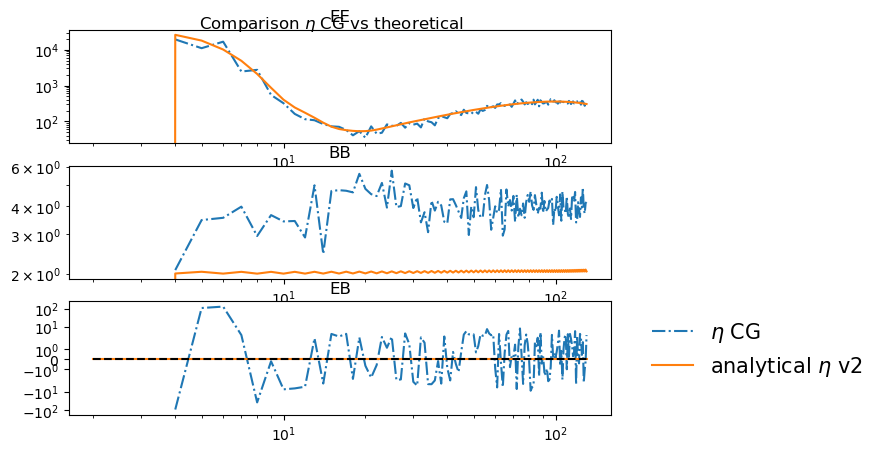

In [36]:
# list_correl = ['TT', 'EE', 'BB', 'TE', 'EB', 'TB']
list_correl = ['EE', 'BB', 'EB']

ell_arange = np.arange(c_ell_approx.shape[1]) + lmin

plt.figure(figsize=(7,5))
plt.suptitle(r"Comparison $\eta$ CG vs theoretical", y=0.91)

for j in range(number_correl_to_plot):
    ax = plt.subplot(311+j)
    plt.title(list_correl[j])

    # plt.plot(ell_arange, c_ell_approx.T[:,j], label='c_ell_approx')
    plt.plot(ell_arange[lmin:], c_ells_eta[j,:]/fksy, '-.', label=r"$\eta$ CG")
    # plt.plot(ell_arange[lmin:], c_ells_eta_overrel[j,:]/fksy, '-.', label=r"Overrelax $\eta$ CG")
    # plt.plot(ell_arange[lmin:], c_ells_eta_v1[j,:]/fksy, '-.', label=r"$\eta$ v1 CG")
    # plt.plot(ell_arange[lmin:], c_ells_eta_overrel_v1[j,:]/fksy, '-.', label=r"Overrelax v1 $\eta$ CG")

    # plt.plot(ell_arange, analytical_eta_term[j,:], '-.', label=r"analytical $\eta$")
    plt.plot(ell_arange, analytical_eta_term_2[j,:], label=r"analytical $\eta$ v2")
    # plt.plot(ell_arange[lmin:], 1/_cl_noise_harm, '-.', label=r"$N_c$")
    # plt.plot(ell_arange[lmin:], 1/theoretical_r0_total[j,:], label='C_approx')
    # if j < nstokes:
    #     plt.plot([ell_arange[0], ell_arange[-1]], [1,1], '--', color='black')
    # plt.plot([ell_arange[0], ell_arange[-1]], [0,0], '--', color='black')
    if nstokes == 3 and j < number_correl_to_plot-2:
        plt.xticks(color='w')

    if j <= nstokes-1:
        plt.loglog()
        # plt.ylim(ymin=noise_level/10.)
    else:
        plt.xscale('log')
        plt.yscale('symlog')
    # plt.legend()
    if j == position_legend:
        plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
        plt.plot([ell_arange[0], ell_arange[-1]], [0,0], '--', color='black')


plt.show()

/Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  fig.canvas.print_figure(bytes_io, **kw)


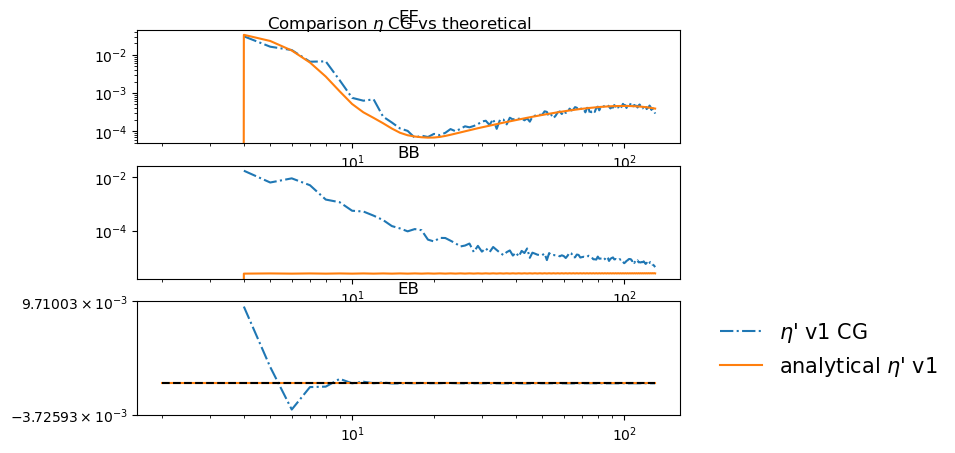

In [37]:
# list_correl = ['TT', 'EE', 'BB', 'TE', 'EB', 'TB']
list_correl = ['EE', 'BB', 'EB']

ell_arange = np.arange(c_ell_approx.shape[1]) + lmin

plt.figure(figsize=(7,5))
plt.suptitle(r"Comparison $\eta$ CG vs theoretical", y=0.91)

for j in range(number_correl_to_plot):
    ax = plt.subplot(311+j)
    plt.title(list_correl[j])

    # plt.plot(ell_arange, c_ell_approx.T[:,j], label='c_ell_approx')
    # plt.plot(ell_arange[lmin:], c_ells_eta[j,:]/fksy, '-.', label=r"$\eta$ CG")
    # plt.plot(ell_arange[lmin:], c_ells_eta_overrel[j,:]/fksy, '-.', label=r"Overrelax $\eta$ CG")
    plt.plot(ell_arange[lmin:], c_ells_eta_v1[j,:]/fksy, '-.', label=r"$\eta$' v1 CG")
    # plt.plot(ell_arange[lmin:], c_ells_eta_overrel_v1[j,:]/fksy, '-.', label=r"Overrelax v1 $\eta$ CG")

    # plt.plot(ell_arange, analytical_eta_term[j,:], '-.', label=r"analytical $\eta$")
    # plt.plot(ell_arange, analytical_eta_term_2[j,:], label=r"analytical $\eta$ v2")
    plt.plot(ell_arange, analytical_eta_term_v1[j,:], label=r"analytical $\eta$' v1")
    # plt.plot(ell_arange[lmin:], 1/_cl_noise_harm, '-.', label=r"$N_c$")
    # plt.plot(ell_arange[lmin:], 1/theoretical_r0_total[j,:], label='C_approx')
    # if j < nstokes:
    #     plt.plot([ell_arange[0], ell_arange[-1]], [1,1], '--', color='black')
    # plt.plot([ell_arange[0], ell_arange[-1]], [0,0], '--', color='black')
    if nstokes == 3 and j < number_correl_to_plot-2:
        plt.xticks(color='w')

    if j <= nstokes-1:
        plt.loglog()
        # plt.ylim(ymin=noise_level/10.)
    else:
        plt.xscale('log')
        plt.yscale('symlog')
    # plt.legend()
    if j == position_legend:
        plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
        plt.plot([ell_arange[0], ell_arange[-1]], [0,0], '--', color='black')


plt.show()

In [38]:
N_c_inv = jnp.copy(BtinvNB[0,0])
N_c_inv = N_c_inv.at[...,mask!=0].set(1/BtinvNB[0,0,mask!=0]/hp.nside2resol(nside)**2)

product_1 = np.einsum('cfp,ckp->fkp', BtinvN_sqrt, BtinvNB)#*N_c_inv

product_2 = np.einsum('ckp,kfp->cfp', BtinvNB, BtinvN_sqrt)

In [39]:
print(np.einsum('fkp,cfp->ckp', product_1, product_2)[:,:,100]/BtinvNB[0,0,100])
print(np.einsum('cfp,fkp->ckp', product_2, product_1)[:,:,100]/BtinvNB[0,0,100])


[[  1.          -4.72711814  -3.02899876]
 [ -4.72711814 132.70599784  10.36831334]
 [ -3.02899876  10.36831334  21.6719946 ]]
[[  1.          -4.72711814  -3.02899876]
 [ -4.72711814 132.70599784  10.36831334]
 [ -3.02899876  10.36831334  21.6719946 ]]


In [40]:
test_map_random_x = jax.random.normal(jax_key_PNRG, shape=(number_frequencies,nstokes,npix))

test_noise = np.einsum('kcp,cfp,fsp->ksp', BtinvNB, BtinvN_sqrt, test_map_random_x)[0]

test_noise_extended = np.vstack([np.zeros_like(test_noise[0]), test_noise])
cl_noise_test = hp.anafast(test_noise_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

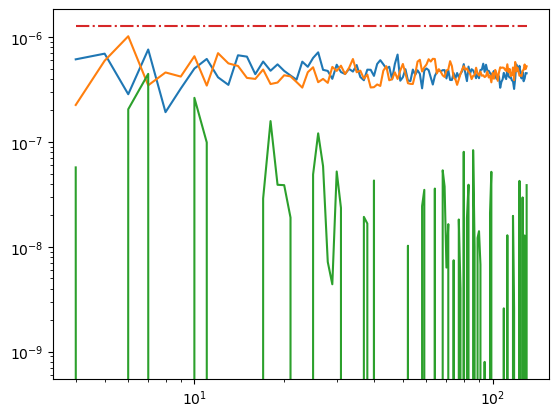

In [41]:
plt.plot(ell_arange[lmin:], cl_noise_test.T)
plt.plot(ell_arange[lmin:], _cl_noise_harm, '-.', label=r"$N_c$")
plt.loglog()
plt.show()

In [42]:
test_map_random_y = jax.random.normal(jax_key_PNRG, shape=(number_frequencies,nstokes,npix))

N_c_inv = jnp.copy(BtinvNB[0,0])
N_c_inv = N_c_inv.at[...,mask!=0].set(1/BtinvNB[0,0,mask!=0]/hp.nside2resol(nside)**2)

test_noise_2 = np.einsum('kcp,cfp,fsp->ksp', BtinvNB, BtinvN_sqrt, test_map_random_y)[0]*N_c_inv

test_noise_2_extended = np.vstack([np.zeros_like(test_noise_2[0]), test_noise_2])
cl_noise_test_2 = hp.anafast(test_noise_2_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

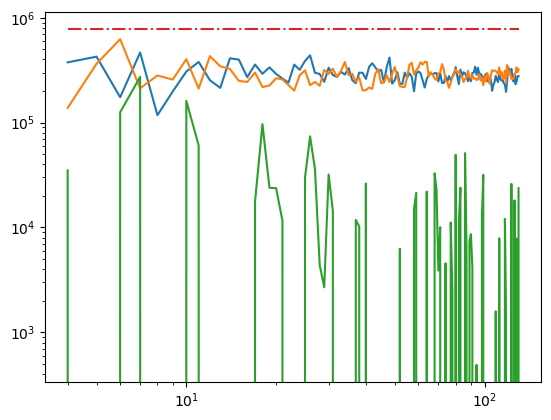

In [43]:
plt.plot(ell_arange[lmin:], cl_noise_test_2.T)
plt.plot(ell_arange[lmin:], 1/_cl_noise_harm, '-.', label=r"$1/N_c$")
plt.loglog()
plt.show()

In [44]:
test_map_random_x = jax.random.normal(jax_key_PNRG, shape=(number_frequencies,nstokes,npix))

N_c_inv = jnp.copy(BtinvNB[0,0])
N_c_inv = N_c_inv.at[...,mask!=0].set(1/BtinvNB[0,0,mask!=0]/hp.nside2resol(nside)**2)

test_noise_3 = np.einsum('kcp,cfp,fsp->ksp', BtinvNB, BtinvN_sqrt, test_map_random_x)[0]*N_c_inv

test_noise_3_extended = np.vstack([np.zeros_like(test_noise_3[0]), test_noise_2])
cl_noise_test_3 = hp.anafast(test_noise_3_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

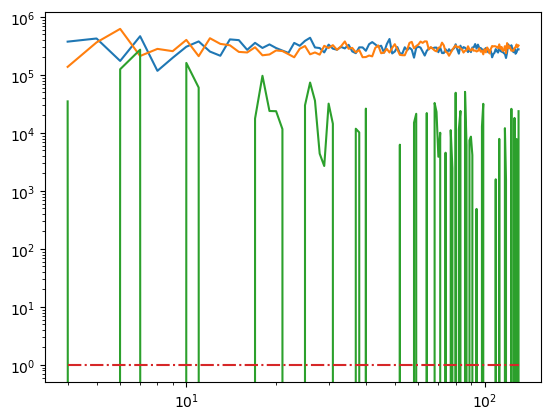

In [45]:
plt.plot(ell_arange[lmin:], cl_noise_test_3.T)
plt.plot(ell_arange[lmin:], np.ones_like(ell_arange[lmin:]), '-.', label=r"$1/N_c$")
plt.loglog()
plt.show()

# Test func

In [248]:
def partial_get_conditional_proba_correction_likelihood_JAX_v2(complete_mixing_matrix, component_eta_maps, red_cov_approx_matrix):
    """ Get conditional probability of correction term in the likelihood from the full mixing matrix

        The associated conditional probability is given by : - (eta^t C_approx^{-1/2} ( C_approx^{-1} + N_c^{-1} )^{-1} C_approx^{-1/2} eta
        Or :
        - (eta^t C_approx^{-1/2} ( C_approx^{-1} + (E^t (B^t N^{-1} B)^{-1} E) ^{-1}) C_approx^{-1/2} \eta

        Parameters
        ----------
        :param complete_mixing_matrix: full mixing matrix of dimension [component, frequencies]
        :param component_eta_maps: set of eta maps of dimension [component, npix]
        :param red_cov_approx_matrix: covariance matrice approx (C_approx) in harmonic domain, dimension [lmin:lmax, nstokes, nstokes]

        Returns
        -------
        :return: computation of correction term to the likelihood
    """

    # Building the correction term to the likelihood : - (eta^t C_approx^{-1/2} ( C_approx^{-1} + N_c^{-1} )^{-1} C_approx^{-1/2} \eta

    ## Preparing the mixing matrix and C_approx^{-1/2}
    invBtinvNB = get_inv_BtinvNB(MICMAC_sampler_obj.freq_inverse_noise, complete_mixing_matrix, jax_use=True)*jhp.nside2resol(MICMAC_sampler_obj.nside)**2
    red_cov_approx_matrix_msqrt = jnp.linalg.pinv(get_sqrt_reduced_matrix_from_matrix_jax(red_cov_approx_matrix))

    ## Computation of C_approx^{-1/2} eta
    component_eta_maps_2 = maps_x_red_covariance_cell_JAX(component_eta_maps, red_cov_approx_matrix_msqrt, nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter)

    ## Preparing the operator ( C_approx^{-1} + N_c^{-1} )^{-1}
    N_c_inv = jnp.zeros_like(invBtinvNB[0,0])
    N_c_inv = N_c_inv.at[...,MICMAC_sampler_obj.mask!=0].set(1/invBtinvNB[0,0,MICMAC_sampler_obj.mask!=0])


    first_term_left = lambda x : maps_x_red_covariance_cell_JAX(x.reshape((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix)), 
                                                                jnp.linalg.pinv(red_cov_approx_matrix), nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter)
    
    def second_term_left(x):
        return x.reshape((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix))*N_c_inv

    func_left_term = lambda x : (first_term_left(x) + second_term_left(x)).ravel()

    ## Computation of ( C_approx^{-1} + N_c^{-1} )^{-1} C_approx^{-1/2} eta
    initial_guess = jnp.zeros((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix))
    right_member = jnp.copy(component_eta_maps_2)
    inverse_term, number_iterations = jsp.sparse.linalg.cg(func_left_term, right_member.ravel(), x0=initial_guess.ravel(), tol=MICMAC_sampler_obj.tolerance_CG, atol=MICMAC_sampler_obj.tolerance_CG, maxiter=MICMAC_sampler_obj.limit_iter_cg)

    ## Computation of C_approx^{-1/2} ( C_approx^{-1} + N_c^{-1} )^{-1} C_approx^{-1/2} eta
    component_eta_maps_3 = maps_x_red_covariance_cell_JAX(inverse_term.reshape(MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix), red_cov_approx_matrix_msqrt, nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter)
    return component_eta_maps_3


def partial_get_conditional_proba_correction_likelihood_JAX_v2b(complete_mixing_matrix, component_eta_maps, red_cov_approx_matrix, previous_inverse=jnp.empty(0)):
    """ Get conditional probability of correction term in the likelihood from the full mixing matrix

        The associated conditional probability is given by : - (eta^t C_approx^{-1/2} ( C_approx^{-1} + N_c^{-1} )^{-1} C_approx^{-1/2} eta
        Or :
        - (eta^t C_approx^{-1/2} ( C_approx^{-1} + (E^t (B^t N^{-1} B)^{-1} E) ^{-1}) C_approx^{-1/2} \eta

        Parameters
        ----------
        :param complete_mixing_matrix: full mixing matrix of dimension [component, frequencies]
        :param component_eta_maps: set of eta maps of dimension [component, npix]
        :param red_cov_approx_matrix: covariance matrice approx (C_approx) in harmonic domain, dimension [lmin:lmax, nstokes, nstokes]

        Returns
        -------
        :return: computation of correction term to the likelihood
    """

    # Building the correction term to the likelihood : - (eta^t C_approx^{-1/2} ( C_approx^{-1} + N_c^{-1} )^{-1} C_approx^{-1/2} \eta

    ## Preparing the mixing matrix and C_approx^{-1/2}
    invBtinvNB = get_inv_BtinvNB(MICMAC_sampler_obj.freq_inverse_noise, complete_mixing_matrix, jax_use=True)*jhp.nside2resol(MICMAC_sampler_obj.nside)**2
    
    red_cov_approx_matrix_sqrt = get_sqrt_reduced_matrix_from_matrix_jax(red_cov_approx_matrix)

    ## Computation of C_approx^{-1/2} eta
    # component_eta_maps_2 = maps_x_red_covariance_cell_JAX(component_eta_maps, red_cov_approx_matrix_msqrt, nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter)

    ## Preparing the operator ( C_approx^{-1} + N_c^{-1} )^{-1}
    N_c_inv = jnp.zeros_like(invBtinvNB[0,0])
    N_c_inv = N_c_inv.at[...,MICMAC_sampler_obj.mask!=0].set(1/invBtinvNB[0,0,MICMAC_sampler_obj.mask!=0])
    # N_c_inv = N_c_inv.at[...,MICMAC_sampler_obj.mask==0].set(10**(15))

    # operator_harmonic = jnp.linalg.pinv(red_cov_approx_matrix)
    # operator_pixel = 
    
    first_part_left = lambda x : maps_x_red_covariance_cell_JAX(x.reshape((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix)), red_cov_approx_matrix_sqrt, nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter)
    
    def second_part_left(x):
        return x.reshape((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix))*N_c_inv

    third_part_term_left = lambda x : maps_x_red_covariance_cell_JAX(x.reshape((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix)), red_cov_approx_matrix_sqrt, nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter).ravel()

    # func_left_term = lambda x : (first_term_left(x) + second_term_left(x)).ravel()
    func_left_term = lambda x : x.ravel() + third_part_term_left(second_part_left(first_part_left(x))).ravel()

    ## Computation of ( C_approx^{-1} + N_c^{-1} )^{-1} C_approx^{-1/2} eta
    # initial_guess = jnp.zeros((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix))
    initial_guess = jnp.copy(component_eta_maps)#*invBtinvNB[0,0]

    if previous_inverse.size != 0:
        initial_guess = jnp.copy(previous_inverse)
    # initial_guess = (maps_x_red_covariance_cell_JAX(component_eta_maps, red_cov_approx_matrix, nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter)*N_c_inv).ravel()
    right_member = jnp.copy(component_eta_maps)
    inverse_term, number_iterations = jsp.sparse.linalg.cg(func_left_term, right_member.ravel(), x0=initial_guess.ravel(), tol=MICMAC_sampler_obj.tolerance_CG, atol=MICMAC_sampler_obj.tolerance_CG, maxiter=MICMAC_sampler_obj.limit_iter_cg)
    
    # iterative_class = jopt.IterativeRefinement(matvec_A=func_left_term,solve=jsp.sparse.linalg.cg,maxiter=MICMAC_sampler_obj.limit_iter_cg,tol=MICMAC_sampler_obj.tolerance_CG)
    # iterative_class = jopt.IterativeRefinement(matvec_A=func_left_term, solve=jsp.sparse.linalg.cg,maxiter=MICMAC_sampler_obj.limit_iter_cg,tol=MICMAC_sampler_obj.tolerance_CG)

    # inverse_term = iterative_class.solve(A=func_left_term, b=right_member.ravel(),maxiter=MICMAC_sampler_obj.limit_iter_cg)[0]
    
    return inverse_term.reshape(MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix)



def partial_get_conditional_proba_correction_likelihood_JAX_v2c(complete_mixing_matrix, component_eta_maps, red_cov_approx_matrix, previous_inverse=jnp.empty(0)):
    """ Get conditional probability of correction term in the likelihood from the full mixing matrix

        The associated conditional probability is given by : - (eta^t C_approx^{-1/2} ( C_approx^{-1} + N_c^{-1} )^{-1} C_approx^{-1/2} eta
        Or :
        - (eta^t C_approx^{-1/2} ( C_approx^{-1} + (E^t (B^t N^{-1} B)^{-1} E) ^{-1}) C_approx^{-1/2} \eta

        Parameters
        ----------
        :param complete_mixing_matrix: full mixing matrix of dimension [component, frequencies]
        :param component_eta_maps: set of eta maps of dimension [component, npix]
        :param red_cov_approx_matrix: covariance matrice approx (C_approx) in harmonic domain, dimension [lmin:lmax, nstokes, nstokes]

        Returns
        -------
        :return: computation of correction term to the likelihood
    """

    # Building the correction term to the likelihood : - (eta^t C_approx^{-1/2} ( C_approx^{-1} + N_c^{-1} )^{-1} C_approx^{-1/2} \eta

    ## Preparing the mixing matrix and C_approx^{-1/2}
    invBtinvNB = get_inv_BtinvNB(MICMAC_sampler_obj.freq_inverse_noise, complete_mixing_matrix, jax_use=True)*jhp.nside2resol(MICMAC_sampler_obj.nside)**2
    
    red_cov_approx_matrix_sqrt = get_sqrt_reduced_matrix_from_matrix_jax(red_cov_approx_matrix)

    ## Computation of C_approx^{-1/2} eta
    # component_eta_maps_2 = maps_x_red_covariance_cell_JAX(component_eta_maps, red_cov_approx_matrix_msqrt, nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter)

    ## Preparing the operator ( C_approx^{-1} + N_c^{-1} )^{-1}
    N_c_inv = jnp.copy(invBtinvNB[0,0])
    N_c_inv = N_c_inv.at[...,MICMAC_sampler_obj.mask!=0].set(1/invBtinvNB[0,0,MICMAC_sampler_obj.mask!=0])
    # N_c_inv = N_c_inv.at[...,MICMAC_sampler_obj.mask==0].set(10**(15))


    sqrt_harmonic_part_left = lambda x : maps_x_red_covariance_cell_JAX(x.reshape((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix)), red_cov_approx_matrix_sqrt, nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter)
    
    def second_part_left_1(x):
        return x.reshape((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix))*N_c_inv

    second_part_left_2 = lambda x : maps_x_red_covariance_cell_JAX(x.reshape((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix)), jnp.linalg.pinv(red_cov_approx_matrix), nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter)

    # third_part_term_left = lambda x : maps_x_red_covariance_cell_JAX(x.reshape((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix)), red_cov_approx_matrix_sqrt, nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter).ravel()

    # func_left_term = lambda x : (first_term_left(x) + second_term_left(x)).ravel()

    def func_left_term(x):
        sqrt_harmonic_part_left_term = sqrt_harmonic_part_left(x)
        second_left_term = second_part_left_1(sqrt_harmonic_part_left_term) + second_part_left_2(sqrt_harmonic_part_left_term)
        return sqrt_harmonic_part_left(second_left_term).ravel()

    ## Computation of ( C_approx^{-1} + N_c^{-1} )^{-1} C_approx^{-1/2} eta
    # initial_guess = jnp.zeros((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix))
    initial_guess = jnp.copy(component_eta_maps)#*invBtinvNB[0,0]

    if previous_inverse.size != 0:
        initial_guess = jnp.copy(previous_inverse)
    # initial_guess = (maps_x_red_covariance_cell_JAX(component_eta_maps, red_cov_approx_matrix, nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter)*N_c_inv).ravel()
    right_member = jnp.copy(component_eta_maps)
    
    inverse_term, number_iterations = jsp.sparse.linalg.cg(func_left_term, right_member.ravel(), x0=initial_guess.ravel(), tol=MICMAC_sampler_obj.tolerance_CG, atol=MICMAC_sampler_obj.tolerance_CG, maxiter=MICMAC_sampler_obj.limit_iter_cg)

    # iterative_class = jopt.IterativeRefinement(matvec_A=func_left_term, solve=jsp.sparse.linalg.cg,maxiter=MICMAC_sampler_obj.limit_iter_cg,tol=MICMAC_sampler_obj.tolerance_CG)

    # inverse_term = iterative_class.solve(A=func_left_term, b=right_member.ravel(),maxiter=MICMAC_sampler_obj.limit_iter_cg)[0]
    

    return inverse_term.reshape(MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix)


In [249]:
# def test_get_conditional_proba_correction_likelihood_JAX_v2(complete_mixing_matrix, component_eta_maps, red_cov_approx_matrix):
#     """ Get conditional probability of correction term in the likelihood from the full mixing matrix

#         The associated conditional probability is given by : - (eta^t C_approx^{-1/2} ( C_approx^{-1} + N_c^{-1} )^{-1} C_approx^{-1/2} eta
#         Or :
#         - (eta^t C_approx^{-1/2} ( C_approx^{-1} + (E^t (B^t N^{-1} B)^{-1} E) ^{-1}) C_approx^{-1/2} \eta

#         Parameters
#         ----------
#         :param complete_mixing_matrix: full mixing matrix of dimension [component, frequencies]
#         :param component_eta_maps: set of eta maps of dimension [component, npix]
#         :param red_cov_approx_matrix: covariance matrice approx (C_approx) in harmonic domain, dimension [lmin:lmax, nstokes, nstokes]

#         Returns
#         -------
#         :return: computation of correction term to the likelihood
#     """

#     # Building the correction term to the likelihood : - (eta^t C_approx^{-1/2} ( C_approx^{-1} + N_c^{-1} )^{-1} C_approx^{-1/2} \eta

#     ## Preparing the mixing matrix and C_approx^{-1/2}
#     invBtinvNB = get_inv_BtinvNB(MICMAC_sampler_obj.freq_inverse_noise, complete_mixing_matrix, jax_use=True)*jhp.nside2resol(MICMAC_sampler_obj.nside)**2
#     red_cov_approx_matrix_msqrt = jnp.linalg.pinv(get_sqrt_reduced_matrix_from_matrix_jax(red_cov_approx_matrix))

#     ## Computation of C_approx^{-1/2} eta
#     component_eta_maps_2 = maps_x_red_covariance_cell_JAX(component_eta_maps, red_cov_approx_matrix_msqrt, nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter)

#     ## Preparing the operator ( C_approx^{-1} + N_c^{-1} )^{-1}
#     N_c_inv = jnp.copy(invBtinvNB[0,0])
#     N_c_inv = N_c_inv.at[...,MICMAC_sampler_obj.mask!=0].set(1/invBtinvNB[0,0,MICMAC_sampler_obj.mask!=0]/jhp.nside2resol(MICMAC_sampler_obj.nside)**2)

#     operator_harmonic = jnp.linalg.pinv(red_cov_approx_matrix)
#     operator_pixel = N_c_inv
    
#     first_term_left = lambda x : maps_x_red_covariance_cell_JAX(x.reshape((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix)), operator_harmonic, nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter)
#     def second_term_left(x):
#         return x.reshape((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix))*operator_pixel

#     func_left_term = lambda x : (first_term_left(x) + second_term_left(x)).ravel()

#     ## Computation of ( C_approx^{-1} + N_c^{-1} )^{-1} C_approx^{-1/2} eta
#     # initial_guess = jnp.zeros((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix))
#     initial_guess = jnp.copy(component_eta_maps)
#     right_member = jnp.copy(component_eta_maps_2)
#     inverse_term, number_iterations = jsp.sparse.linalg.cg(func_left_term, right_member.ravel(), x0=initial_guess.ravel(), tol=MICMAC_sampler_obj.tolerance_CG, atol=MICMAC_sampler_obj.tolerance_CG, maxiter=MICMAC_sampler_obj.limit_iter_cg)

#     ## Computation of C_approx^{-1/2} ( C_approx^{-1} + N_c^{-1} )^{-1} C_approx^{-1/2} eta
#     component_eta_maps_3 = maps_x_red_covariance_cell_JAX(inverse_term.reshape(MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix), red_cov_approx_matrix_msqrt, nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter)

#     # And finally eta^t C_approx^{-1/2} ( C_approx^{-1} + N_c^{-1} )^{-1} C_approx^{-1/2} eta
#     # second_term_complete = jnp.einsum('sk,sk', component_eta_maps, component_eta_maps_3)
#     second_term_complete = jnp.einsum('sp,p,sp', component_eta_maps, MICMAC_sampler_obj.mask, component_eta_maps_3)
#     return -(-0 + second_term_complete)/2.*jhp.nside2resol(MICMAC_sampler_obj.nside)**2

# def test_get_conditional_proba_correction_likelihood_JAX_v2b(complete_mixing_matrix, component_eta_maps, red_cov_approx_matrix):
#     """ Get conditional probability of correction term in the likelihood from the full mixing matrix

#         The associated conditional probability is given by : - (eta^t C_approx^{-1/2} ( C_approx^{-1} + N_c^{-1} )^{-1} C_approx^{-1/2} eta
#         Or :
#         - (eta^t C_approx^{-1/2} ( C_approx^{-1} + (E^t (B^t N^{-1} B)^{-1} E) ^{-1}) C_approx^{-1/2} \eta

#         Parameters
#         ----------
#         :param complete_mixing_matrix: full mixing matrix of dimension [component, frequencies]
#         :param component_eta_maps: set of eta maps of dimension [component, npix]
#         :param red_cov_approx_matrix: covariance matrice approx (C_approx) in harmonic domain, dimension [lmin:lmax, nstokes, nstokes]

#         Returns
#         -------
#         :return: computation of correction term to the likelihood
#     """

#     # Building the correction term to the likelihood : - (eta^t C_approx^{-1/2} ( C_approx^{-1} + N_c^{-1} )^{-1} C_approx^{-1/2} \eta

#     ## Preparing the mixing matrix and C_approx^{-1/2}
#     invBtinvNB = get_inv_BtinvNB(MICMAC_sampler_obj.freq_inverse_noise, complete_mixing_matrix, jax_use=True)*jhp.nside2resol(MICMAC_sampler_obj.nside)**2
    
#     red_cov_approx_matrix_sqrt = get_sqrt_reduced_matrix_from_matrix_jax(red_cov_approx_matrix)

#     ## Computation of C_approx^{-1/2} eta
#     # component_eta_maps_2 = maps_x_red_covariance_cell_JAX(component_eta_maps, red_cov_approx_matrix_msqrt, nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter)

#     ## Preparing the operator ( C_approx^{-1} + N_c^{-1} )^{-1}
#     N_c_inv = jnp.copy(invBtinvNB[0,0])
#     N_c_inv = N_c_inv.at[...,MICMAC_sampler_obj.mask!=0].set(1/invBtinvNB[0,0,MICMAC_sampler_obj.mask!=0]/jhp.nside2resol(MICMAC_sampler_obj.nside)**2)

#     operator_harmonic = jnp.linalg.pinv(red_cov_approx_matrix)
#     operator_pixel = N_c_inv
    
#     first_part_left = lambda x : maps_x_red_covariance_cell_JAX(x.reshape((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix)), red_cov_approx_matrix_sqrt, nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter)
    
#     def second_part_left(x):
#         return x.reshape((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix))*operator_pixel

#     third_part_term_left = lambda x : maps_x_red_covariance_cell_JAX(x.reshape((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix)), red_cov_approx_matrix_sqrt, nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter).ravel()

#     # func_left_term = lambda x : (first_term_left(x) + second_term_left(x)).ravel()
#     func_left_term = lambda x : x.ravel() + third_part_term_left(second_part_left(first_part_left(x))).ravel()

#     ## Computation of ( C_approx^{-1} + N_c^{-1} )^{-1} C_approx^{-1/2} eta
#     # initial_guess = jnp.zeros((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix))
#     initial_guess = jnp.copy(component_eta_maps)
    
    
#     right_member = jnp.copy(component_eta_maps)
#     inverse_term, number_iterations = jsp.sparse.linalg.cg(func_left_term, right_member.ravel(), x0=initial_guess.ravel(), tol=MICMAC_sampler_obj.tolerance_CG, atol=MICMAC_sampler_obj.tolerance_CG, maxiter=MICMAC_sampler_obj.limit_iter_cg)

#     ## Computation of C_approx^{-1/2} ( C_approx^{-1} + N_c^{-1} )^{-1} C_approx^{-1/2} eta
#     # component_eta_maps_3 = maps_x_red_covariance_cell_JAX(inverse_term.reshape(MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix), red_cov_approx_matrix_msqrt, nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter)

#     # And finally eta^t C_approx^{-1/2} ( C_approx^{-1} + N_c^{-1} )^{-1} C_approx^{-1/2} eta
#     # second_term_complete = jnp.einsum('sk,sk', component_eta_maps, inverse_term.reshape(MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix))
#     second_term_complete = jnp.einsum('sp,p,sp', component_eta_maps, MICMAC_sampler_obj.mask, inverse_term.reshape(MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix))
#     return -(-0 + second_term_complete)/2.*jhp.nside2resol(MICMAC_sampler_obj.nside)**2


In [250]:
# true_mask = mask
# fake_mask = np.ones_like(mask)

# MICMAC_sampler_obj.mask = true_mask

In [321]:
MICMAC_sampler_obj.limit_iter_cg = 40
MICMAC_sampler_obj.tolerance_CG = 1e-10

In [325]:
# %%time
# partial_term_1 = partial_get_conditional_proba_correction_likelihood_JAX_v2(mixing_matrix_sampled, eta_maps, red_cov_approx_matrix)

In [323]:
%%time
# partial_term_2 = partial_get_conditional_proba_correction_likelihood_JAX_v2b(mixing_matrix_sampled, eta_maps, red_cov_approx_matrix, previous_inverse=partial_term_2)
partial_term_2 = partial_get_conditional_proba_correction_likelihood_JAX_v2b(mixing_matrix_sampled, eta_maps, red_cov_approx_matrix, previous_inverse=jnp.empty(0))

CPU times: user 12.1 s, sys: 1.68 s, total: 13.8 s
Wall time: 5.33 s


In [324]:
%%time
# partial_term_3 = partial_get_conditional_proba_correction_likelihood_JAX_v2c(mixing_matrix_sampled, eta_maps, red_cov_approx_matrix, previous_inverse=partial_term_3)
partial_term_3 = partial_get_conditional_proba_correction_likelihood_JAX_v2c(mixing_matrix_sampled, eta_maps, red_cov_approx_matrix, previous_inverse=jnp.empty(0))

CPU times: user 17.7 s, sys: 2.49 s, total: 20.2 s
Wall time: 7.72 s


In [310]:
def get_eta_term_back(partial_proba_term, complete_mixing_matrix, red_cov_approx_matrix):
    invBtinvNB = get_inv_BtinvNB(MICMAC_sampler_obj.freq_inverse_noise, complete_mixing_matrix, jax_use=True)*jhp.nside2resol(MICMAC_sampler_obj.nside)**2

    red_cov_approx_matrix_sqrt = micmac.get_sqrt_reduced_matrix_from_matrix(red_cov_approx_matrix)
    N_c_inv = jnp.copy(invBtinvNB[0,0])
    N_c_inv = N_c_inv.at[mask!=0].set(1/invBtinvNB[0,0,mask!=0])
    # N_c_inv = N_c_inv.at[mask==0].set(10**15)

    func_1st_term = lambda x : maps_x_red_covariance_cell_JAX(x.reshape(MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix), red_cov_approx_matrix_sqrt, nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter)

    func_2nd_term_1 = lambda x : maps_x_red_covariance_cell_JAX(x.reshape((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix)), jnp.linalg.pinv(red_cov_approx_matrix), nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter)
    func_2nd_term_2 = lambda x : x.reshape((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix))*N_c_inv

    func_2nd_term = lambda x : (func_2nd_term_1(x) + func_2nd_term_2(x)).ravel()

    total_func = lambda x : func_1st_term(func_2nd_term(func_1st_term(x))).ravel()

    return total_func(partial_proba_term.ravel()).reshape(MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix)


In [311]:
eta_from_partial_1 = get_eta_term_back(partial_term_1, mixing_matrix_sampled, red_cov_approx_matrix)
eta_from_partial_2 = get_eta_term_back(partial_term_2, mixing_matrix_sampled, red_cov_approx_matrix)
eta_from_partial_3 = get_eta_term_back(partial_term_3, mixing_matrix_sampled, red_cov_approx_matrix)

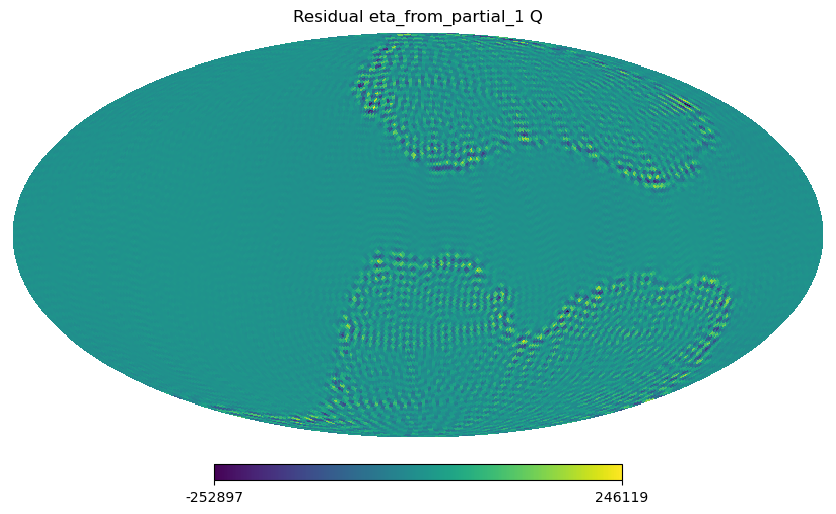

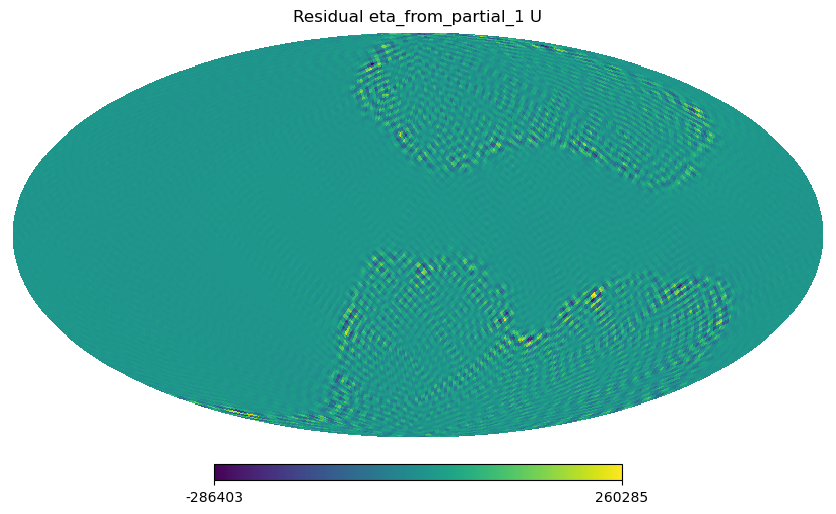

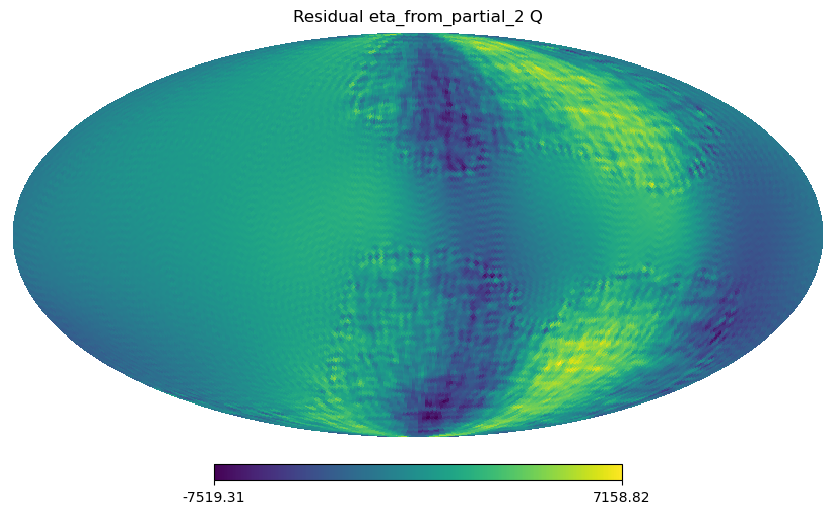

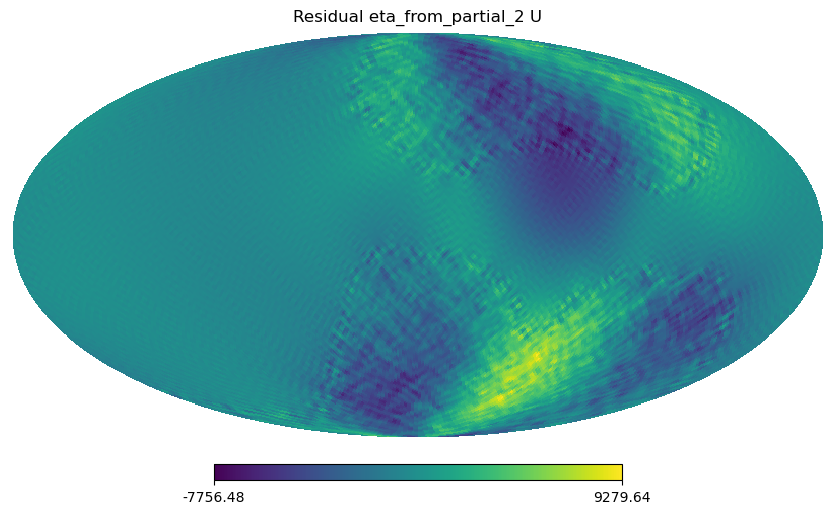

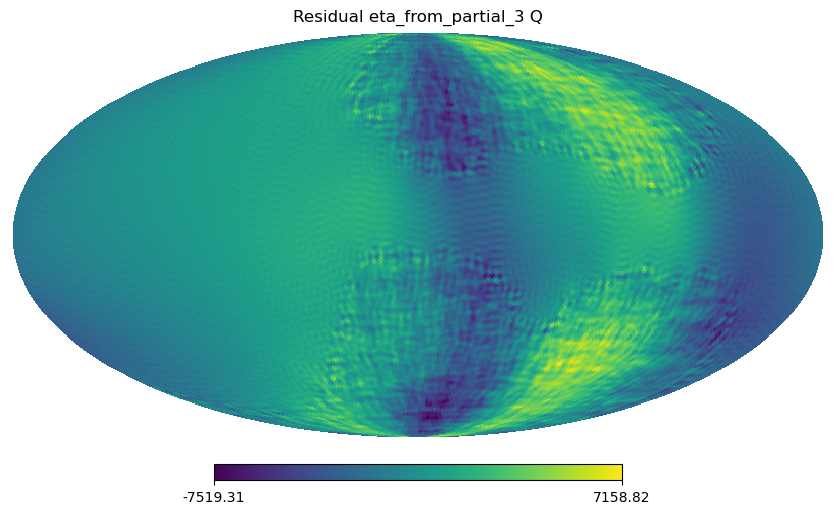

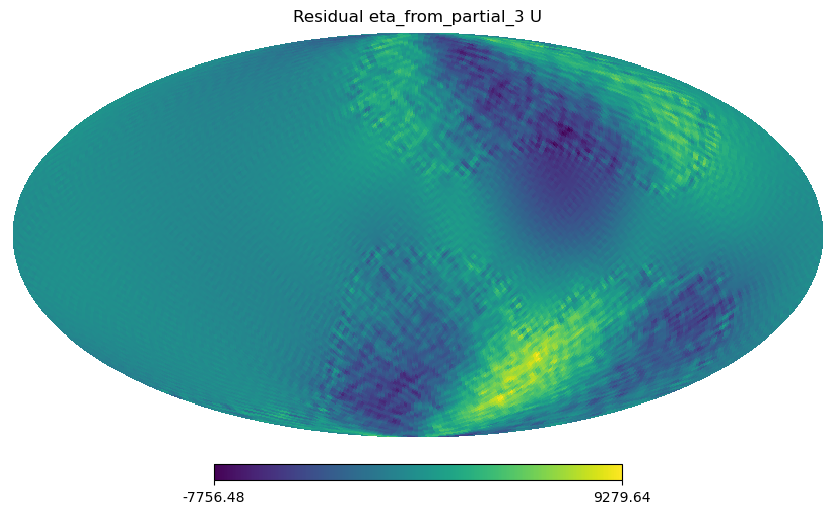

In [312]:
hp.mollview(eta_from_partial_1[0]-eta_maps[0], title='Residual eta_from_partial_1 Q')
hp.mollview(eta_from_partial_1[1]-eta_maps[1], title='Residual eta_from_partial_1 U')
hp.mollview(eta_from_partial_2[0]-eta_maps[0], title='Residual eta_from_partial_2 Q')
hp.mollview(eta_from_partial_2[1]-eta_maps[1], title='Residual eta_from_partial_2 U')
hp.mollview(eta_from_partial_3[0]-eta_maps[0], title='Residual eta_from_partial_3 Q')
hp.mollview(eta_from_partial_3[1]-eta_maps[1], title='Residual eta_from_partial_3 U')

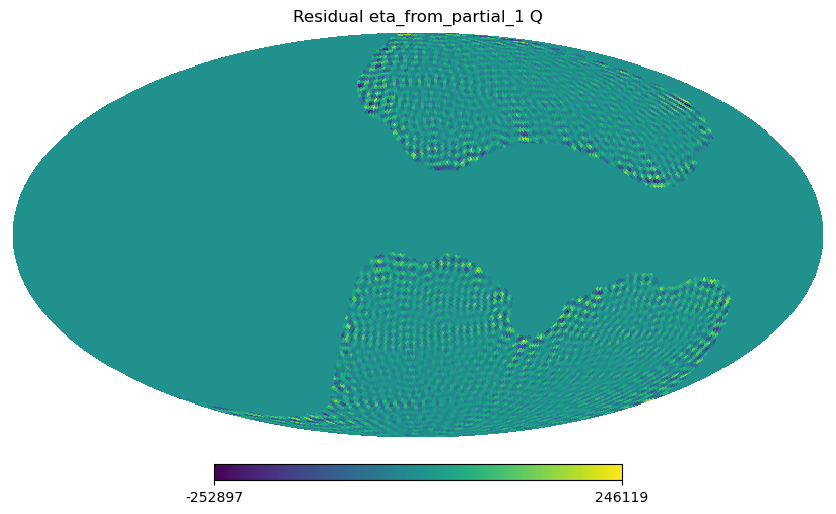

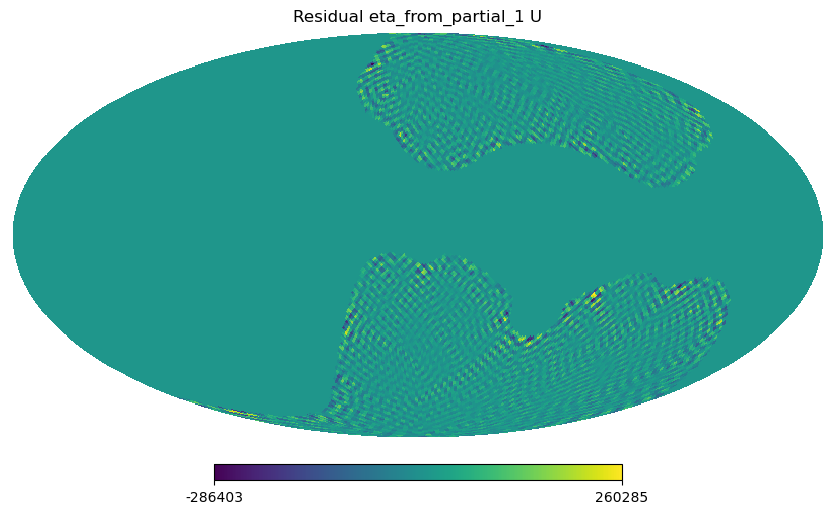

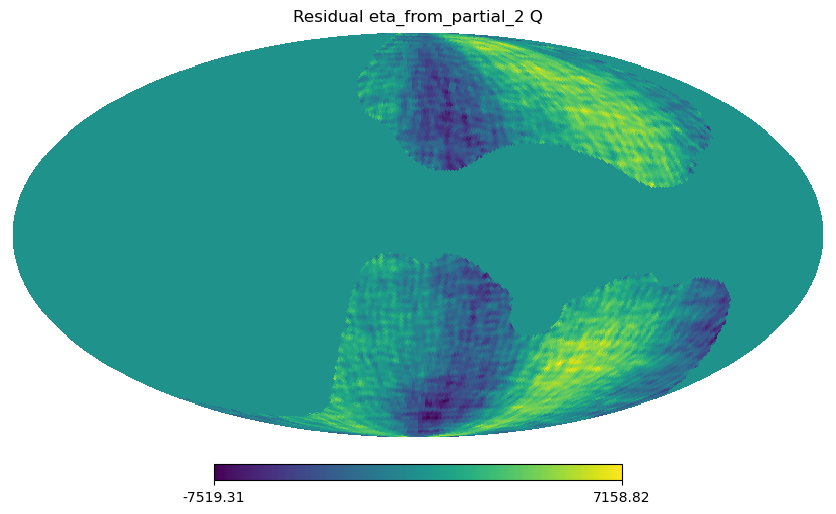

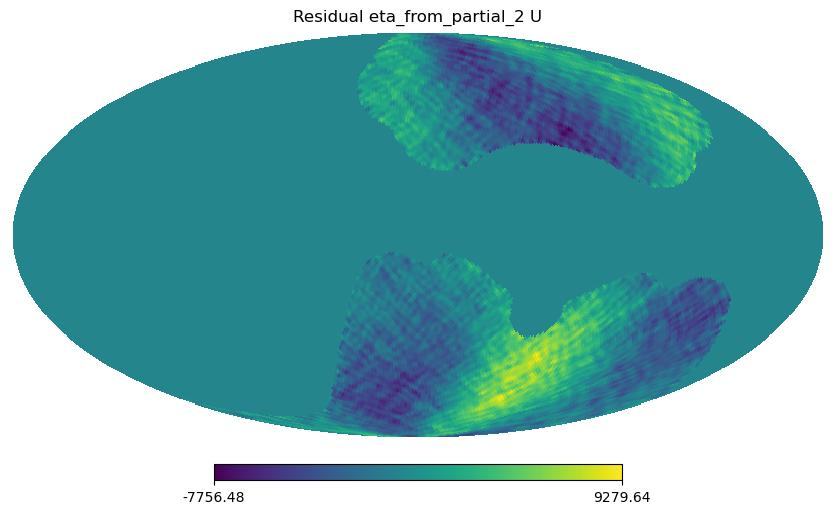

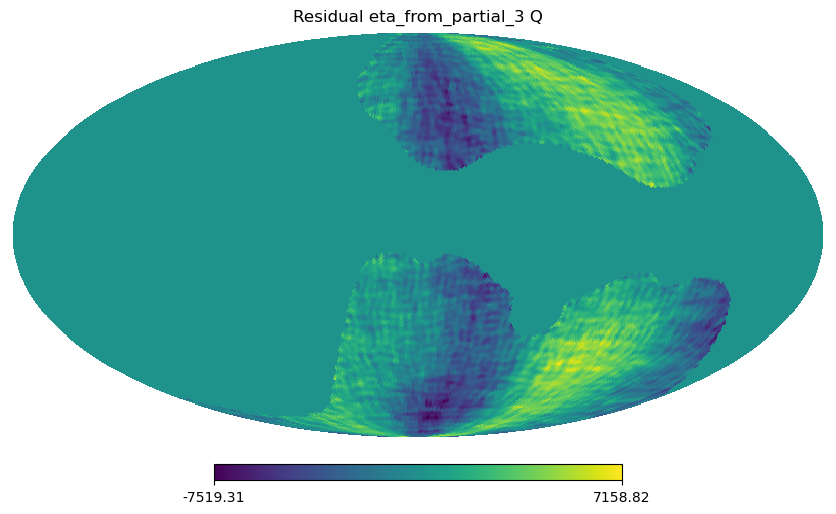

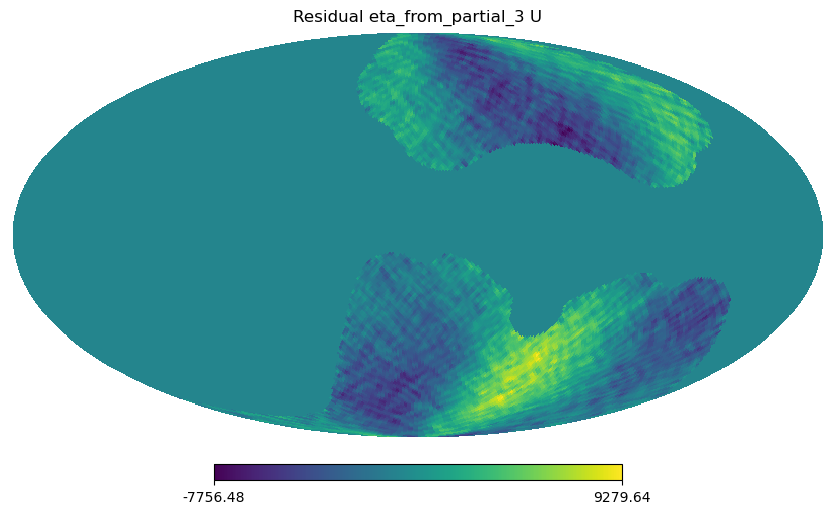

In [313]:
hp.mollview((eta_from_partial_1[0]-eta_maps[0])*MICMAC_sampler_obj.mask, title='Residual eta_from_partial_1 Q')
hp.mollview((eta_from_partial_1[1]-eta_maps[1])*MICMAC_sampler_obj.mask, title='Residual eta_from_partial_1 U')
hp.mollview((eta_from_partial_2[0]-eta_maps[0])*MICMAC_sampler_obj.mask, title='Residual eta_from_partial_2 Q')
hp.mollview((eta_from_partial_2[1]-eta_maps[1])*MICMAC_sampler_obj.mask, title='Residual eta_from_partial_2 U')
hp.mollview((eta_from_partial_3[0]-eta_maps[0])*MICMAC_sampler_obj.mask, title='Residual eta_from_partial_3 Q')
hp.mollview((eta_from_partial_3[1]-eta_maps[1])*MICMAC_sampler_obj.mask, title='Residual eta_from_partial_3 U')

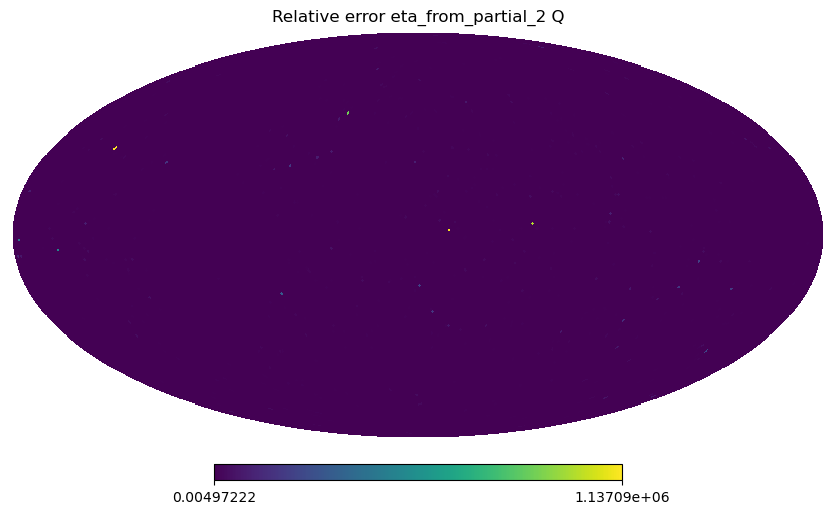

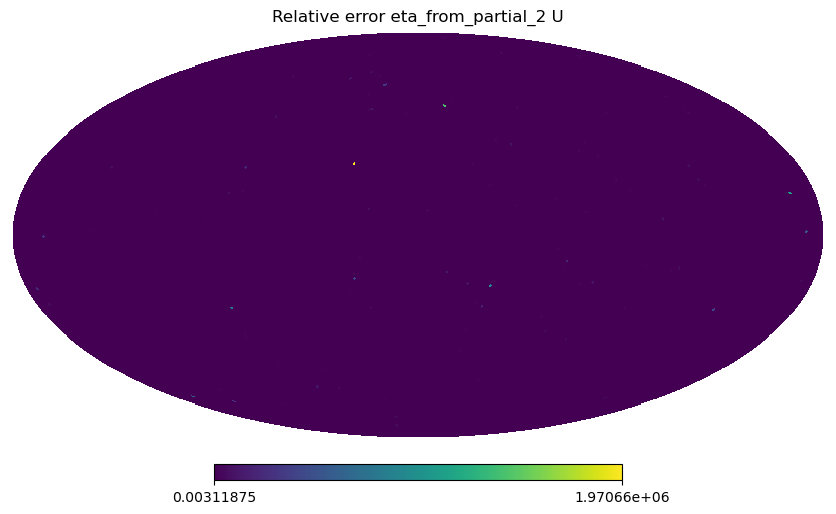

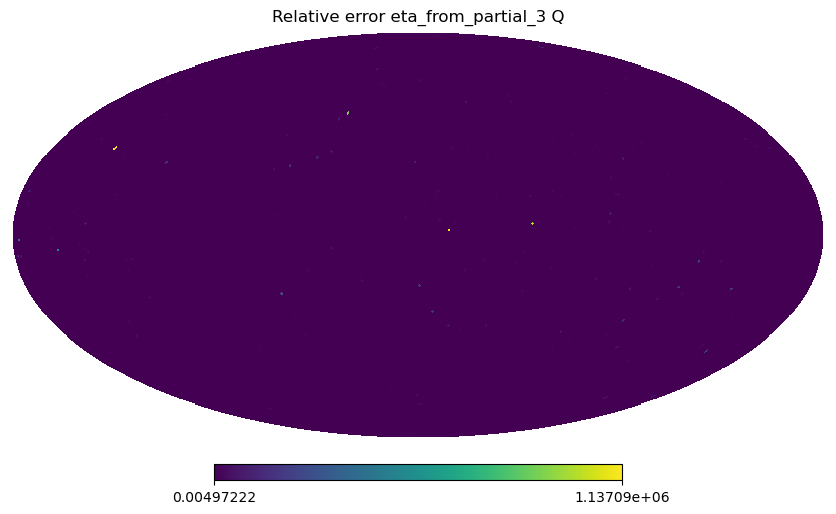

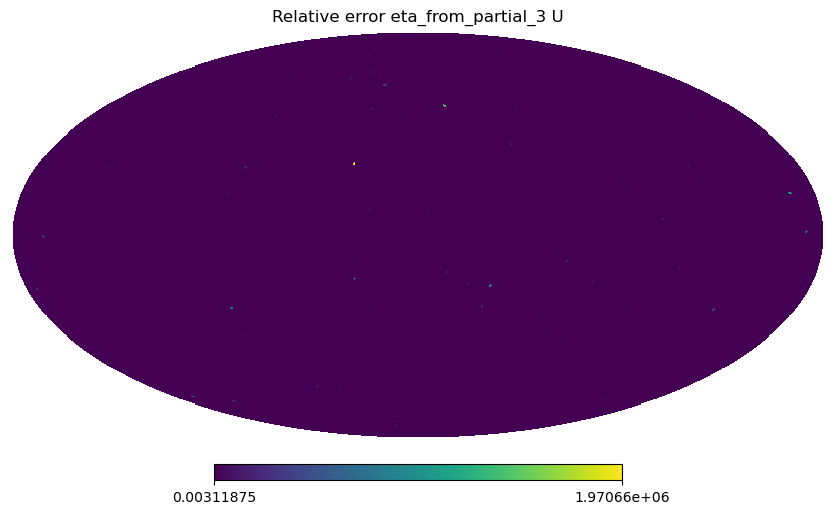

In [314]:
diff_1 = jnp.abs((eta_from_partial_1-eta_maps)/eta_maps)
diff_2 = jnp.abs((eta_from_partial_1-eta_maps)/eta_maps)

# cond = jnp.abs(eta_maps)<100

# diff_1 = diff_1.at[cond].set(0)
# diff_2 = diff_2.at[cond].set(0)

hp.mollview(diff_1[0], title='Relative error eta_from_partial_2 Q')
hp.mollview(diff_1[1], title='Relative error eta_from_partial_2 U')

hp.mollview(diff_2[0], title='Relative error eta_from_partial_3 Q')
hp.mollview(diff_2[1], title='Relative error eta_from_partial_3 U')

# hp.mollview(eta_from_partial_2[1]-eta_maps[1], title='Relative error eta_from_partial_2 U')
# hp.mollview(eta_from_partial_3[0]-eta_maps[0], title='Relative error eta_from_partial_3 Q')
# hp.mollview(eta_from_partial_3[1]-eta_maps[1], title='Relative error eta_from_partial_3 U')

In [315]:
# covariance_unity = jnp.zeros((MICMAC_sampler_obj.lmax+1-MICMAC_sampler_obj.lmin,MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.nstokes))
# covariance_unity = covariance_unity.at[10:100,...].set(jnp.eye(MICMAC_sampler_obj.nstokes))

# eta_from_partial_2b = maps_x_red_covariance_cell_JAX(jnp.copy(eta_from_partial_2), covariance_unity, nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter)
 
# hp.mollview(eta_from_partial_2b[0]-eta_maps[0], title='Residual eta_from_partial_2 Q')
# hp.mollview(eta_from_partial_2b[1]-eta_maps[1], title='Residual eta_from_partial_2 U')

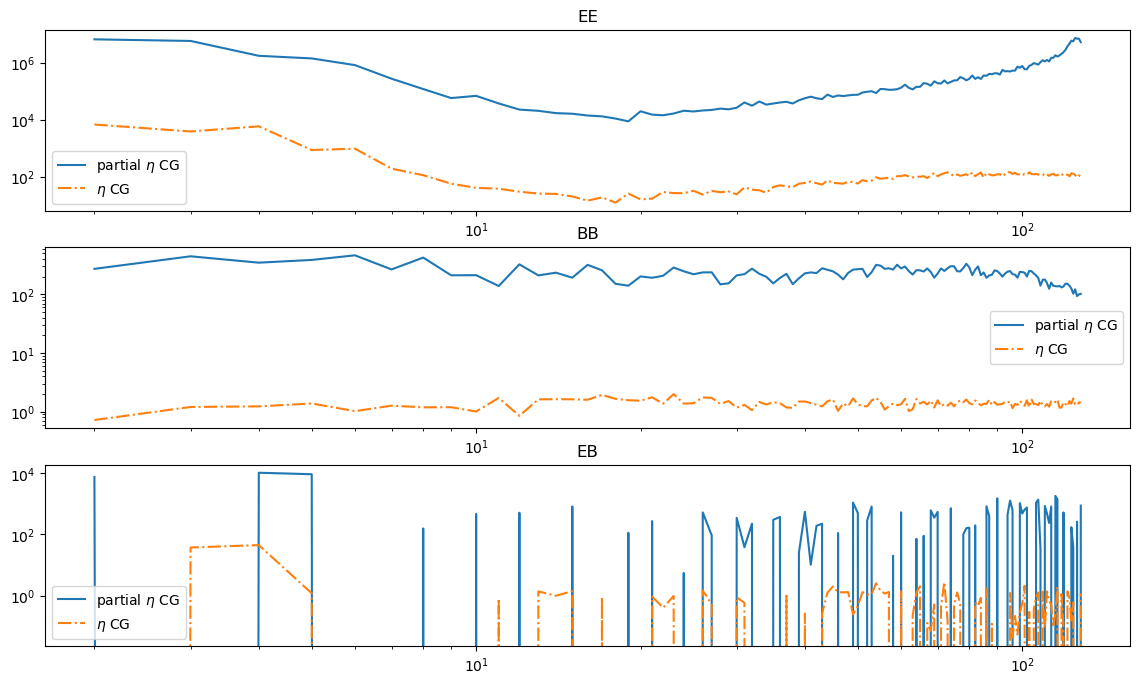

In [316]:
eta_from_partial_ext_1 = np.vstack([np.zeros_like(eta_from_partial_1[0]), eta_from_partial_1])
c_ells_eta_partial_1 = hp.anafast(eta_from_partial_ext_1, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

plt.figure(figsize=(14,8))
for j in range(number_correl_to_plot):
    ax = plt.subplot(311+j)
    plt.title(list_correl[j])
    plt.plot(ell_arange[:lmax-1], c_ells_eta_partial_1[j,:], label=r"partial $\eta$ CG")
    plt.plot(ell_arange[:lmax-1], c_ells_eta[j,:], '-.', label=r"$\eta$ CG")
    plt.loglog()
    plt.legend()
plt.show()

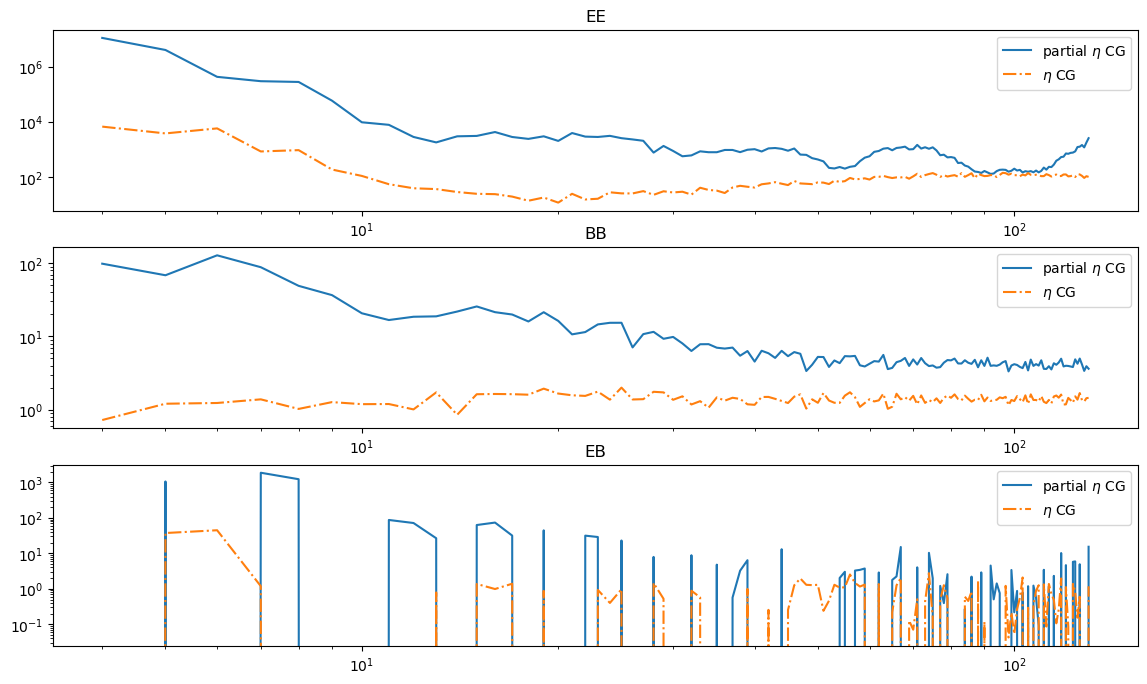

In [317]:
eta_from_partial_ext_2 = np.vstack([np.zeros_like(eta_from_partial_2[0]), eta_from_partial_2])
c_ells_eta_partial_2 = hp.anafast(eta_from_partial_ext_2, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

plt.figure(figsize=(14,8))
for j in range(number_correl_to_plot):
    ax = plt.subplot(311+j)
    plt.title(list_correl[j])
    plt.plot(ell_arange[lmin:], c_ells_eta_partial_2[j,:], label=r"partial $\eta$ CG")
    plt.plot(ell_arange[lmin:], c_ells_eta[j,:], '-.', label=r"$\eta$ CG")
    plt.loglog()
    plt.legend()
plt.show()

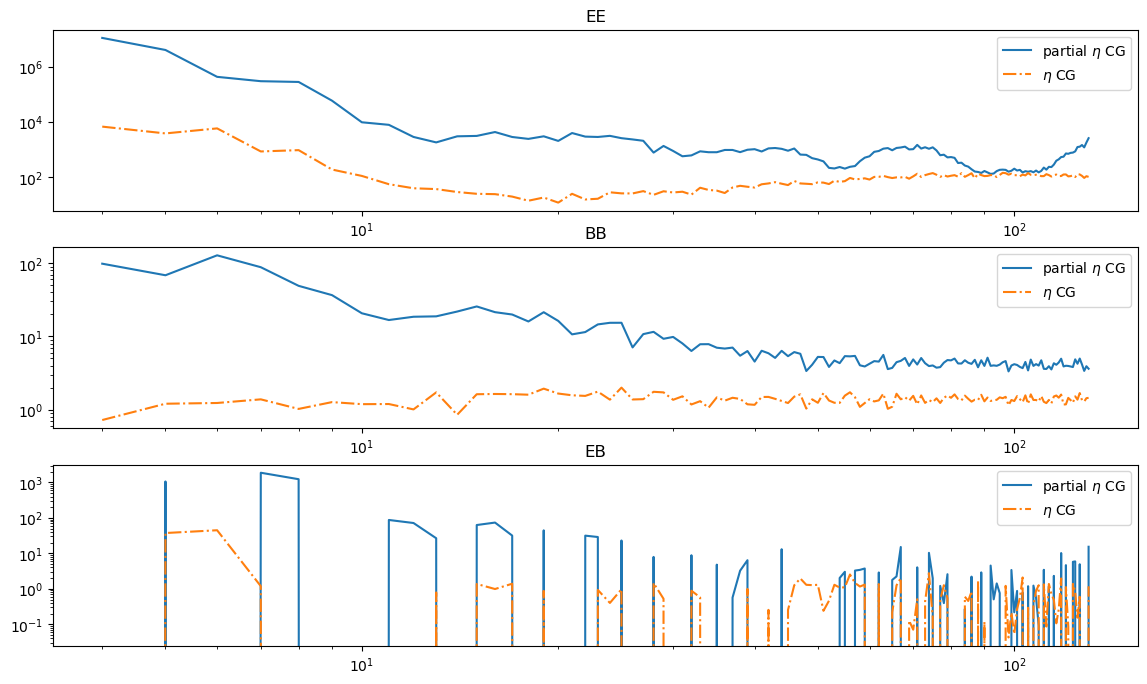

In [318]:
eta_from_partial_ext_3 = np.vstack([np.zeros_like(eta_from_partial_2[0]), eta_from_partial_3])
c_ells_eta_partial_3 = hp.anafast(eta_from_partial_ext_3, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

plt.figure(figsize=(14,8))
for j in range(number_correl_to_plot):
    ax = plt.subplot(311+j)
    plt.title(list_correl[j])
    plt.plot(ell_arange[lmin:], c_ells_eta_partial_3[j,:], label=r"partial $\eta$ CG")
    plt.plot(ell_arange[lmin:], c_ells_eta[j,:], '-.', label=r"$\eta$ CG")
    plt.loglog()
    plt.legend()
plt.show()

In [332]:
log_proba_partial_term_1 = -np.einsum('sp,p,sp', eta_maps, MICMAC_sampler_obj.mask, partial_term_1)*jhp.nside2resol(MICMAC_sampler_obj.nside)**2/2
log_proba_partial_term_2 = -np.einsum('sp,p,sp', eta_maps, MICMAC_sampler_obj.mask, partial_term_2)*jhp.nside2resol(MICMAC_sampler_obj.nside)**2/2
log_proba_partial_term_3 = -np.einsum('sp,p,sp', eta_maps, MICMAC_sampler_obj.mask, partial_term_3)*jhp.nside2resol(MICMAC_sampler_obj.nside)**2/2
# log_proba_partial_term_1 = -np.einsum('sp,sp', eta_maps, partial_term_1)*jhp.nside2resol(MICMAC_sampler_obj.nside)**2/2
# log_proba_partial_term_2 = -np.einsum('sp,sp', eta_maps, partial_term_2)*jhp.nside2resol(MICMAC_sampler_obj.nside)**2/2
# log_proba_partial_term_3 = -np.einsum('sp,sp', eta_maps, partial_term_3)*jhp.nside2resol(MICMAC_sampler_obj.nside)**2/2

In [333]:
# print("log_proba_partial_term_1 = ", log_proba_partial_term_1)
print("log_proba_partial_term_2 = ", log_proba_partial_term_2)
print("log_proba_partial_term_3 = ", log_proba_partial_term_3)

log_proba_partial_term_2 =  -8292.248189329142
log_proba_partial_term_3 =  -8292.248189346807


In [297]:
# print("log_proba_partial_term_1 = ", log_proba_partial_term_1)
print("log_proba_partial_term_2 = ", log_proba_partial_term_2)
print("log_proba_partial_term_3 = ", log_proba_partial_term_3)

log_proba_partial_term_2 =  -5686.215389645613
log_proba_partial_term_3 =  -5686.214654471579


# Tests (unsuccessful) with v1

In [62]:
def partial_get_conditional_proba_correction_likelihood_JAX_v1(self, complete_mixing_matrix, freq_eta_maps, red_cov_approx_matrix):
    """ Get conditional probability of correction term in the likelihood from the full mixing matrix

        The associated conditional probability is given by : - (eta^t C_approx^{-1/2} ( C_approx^{-1} + N_c^{-1} )^{-1} C_approx^{-1/2} eta
        Or :
        - (eta^t N_c^{1/2} ( C_approx^{-1} + (E^t (B^t N^{-1} B)^{-1} E) )^{-1} N_c^{1/2} \eta

        Parameters
        ----------
        :param complete_mixing_matrix: full mixing matrix of dimension [component, frequencies]
        :param component_eta_maps: set of eta maps of dimension [component, npix]
        :param red_cov_approx_matrix: covariance matrice approx (C_approx) in harmonic domain, dimension [lmin:lmax, nstokes, nstokes]

        Returns
        -------
        :return: computation of correction term to the likelihood
    """

    # Building the correction term to the likelihood : - (eta^t C_approx^{-1/2} ( C_approx^{-1} + N_c^{-1} )^{-1} C_approx^{-1/2} \eta

    ## Preparing the mixing matrix and C_approx^{-1/2}
    invBtinvNB = get_inv_BtinvNB(self.freq_inverse_noise, complete_mixing_matrix, jax_use=True)*jhp.nside2resol(self.nside)**2
    BtinvN_sqrt = get_BtinvN(jnp.sqrt(self.freq_inverse_noise), complete_mixing_matrix, jax_use=True)/jhp.nside2resol(self.nside)

    # red_cov_approx_matrix_sqrt = get_sqrt_reduced_matrix_from_matrix_jax(red_cov_approx_matrix)

    ## Computation of C_approx^{-1/2} eta
    # component_eta_maps_2 = maps_x_red_covariance_cell_JAX(component_eta_maps, red_cov_approx_matrix_msqrt, nside=self.nside, lmin=self.lmin, n_iter=self.n_iter)

    ## Preparing the operator ( C_approx^{-1} + N_c^{-1} )^{-1}
    N_c_inv = jnp.copy(invBtinvNB[0,0])
    # N_c_inv = N_c_inv.at[...,self.mask!=0].set(1/invBtinvNB[0,0,self.mask!=0]/jhp.nside2resol(self.nside)**2)
    N_c_inv = N_c_inv.at[...,self.mask!=0].set(1/invBtinvNB[0,0,self.mask!=0])

    operator_harmonic = red_cov_approx_matrix
    # operator_pixel = N_c_inv
    operator_pixel = invBtinvNB[0,0]

    nb_pixels_mask = jnp.size(self.mask[self.mask!=0])

    def first_part_middle(x):
        x_ext = jnp.zeros((self.number_frequencies,self.nstokes,self.npix))
        x_ext = x_ext.at[:,:,self.mask!=0].set(x.reshape((self.number_frequencies,self.nstokes,nb_pixels_mask)))
        return jnp.einsum('kcp,cfp,fsp->ksp', invBtinvNB, BtinvN_sqrt, x_ext)[0]#*N_c_inv#*jhp.nside2resol(self.nside)

    
    second_part_middle_1 = lambda x : maps_x_red_covariance_cell_JAX(x.reshape((self.nstokes,self.npix)), operator_harmonic, nside=self.nside, lmin=self.lmin, n_iter=self.n_iter)
    second_part_middle_2 = lambda x : x.reshape((self.nstokes,self.npix))*operator_pixel

    second_part_middle = lambda x : second_part_middle_1(x).ravel() + second_part_middle_2(x).ravel()

    def third_part_middle(x):
        return (jnp.einsum('cfp,cp,sp->fsp', BtinvN_sqrt, invBtinvNB[:,0,...], x.reshape((self.nstokes,self.npix))))[...,self.mask!=0]

    # func_left_term = lambda x : (first_term_left(x) + second_term_left(x)).ravel()
    # func_left_term = lambda x : x.ravel() + third_part_term_left(second_part_left(first_part_left(x))).ravel()
    func_left_term = lambda x : third_part_middle(second_part_middle(first_part_middle(x))).ravel()

    ## Computation of ( C_approx^{-1} + N_c^{-1} )^{-1} C_approx^{-1/2} eta
    # initial_guess = jnp.zeros((self.nstokes,self.npix))
    # initial_guess = jnp.zeros((self.number_frequencies,self.nstokes,jnp.size(self.mask[self.mask!=0])))
    # initial_guess = jnp.copy(freq_eta_maps)[...,self.mask!=0]
    initial_guess = jnp.zeros((self.number_frequencies,self.nstokes,nb_pixels_mask))
    right_member = jnp.copy(freq_eta_maps)[...,self.mask!=0]

    inverse_term, number_iterations = jsp.sparse.linalg.cg(func_left_term, right_member.ravel(), x0=initial_guess.ravel(), tol=self.tolerance_CG, atol=self.tolerance_CG, maxiter=self.limit_iter_cg)
    eta_middle_term = jnp.zeros((self.number_frequencies,self.nstokes,self.npix))
    eta_middle_term = eta_middle_term.at[...,self.mask!=0].set(inverse_term.reshape((self.number_frequencies,self.nstokes,nb_pixels_mask)))

    return eta_middle_term


def partial_get_conditional_proba_correction_likelihood_JAX_v1b(self, complete_mixing_matrix, freq_eta_maps, red_cov_approx_matrix):
    """ Get conditional probability of correction term in the likelihood from the full mixing matrix

        The associated conditional probability is given by : - (eta^t C_approx^{-1/2} ( C_approx^{-1} + N_c^{-1} )^{-1} C_approx^{-1/2} eta
        Or :
        - (eta^t N_c^{1/2} ( C_approx^{-1} + (E^t (B^t N^{-1} B)^{-1} E) )^{-1} N_c^{1/2} \eta

        Parameters
        ----------
        :param complete_mixing_matrix: full mixing matrix of dimension [component, frequencies]
        :param component_eta_maps: set of eta maps of dimension [component, npix]
        :param red_cov_approx_matrix: covariance matrice approx (C_approx) in harmonic domain, dimension [lmin:lmax, nstokes, nstokes]

        Returns
        -------
        :return: computation of correction term to the likelihood
    """

    # Building the correction term to the likelihood : - (eta^t C_approx^{-1/2} ( C_approx^{-1} + N_c^{-1} )^{-1} C_approx^{-1/2} \eta

    ## Preparing the mixing matrix and C_approx^{-1/2}
    invBtinvNB = get_inv_BtinvNB(self.freq_inverse_noise, complete_mixing_matrix, jax_use=True)*jhp.nside2resol(self.nside)**2
    BtinvN_sqrt = get_BtinvN(jnp.sqrt(self.freq_inverse_noise), complete_mixing_matrix, jax_use=True)/jhp.nside2resol(self.nside)

    # red_cov_approx_matrix_sqrt = get_sqrt_reduced_matrix_from_matrix_jax(red_cov_approx_matrix)

    ## Computation of C_approx^{-1/2} eta
    # component_eta_maps_2 = maps_x_red_covariance_cell_JAX(component_eta_maps, red_cov_approx_matrix_msqrt, nside=self.nside, lmin=self.lmin, n_iter=self.n_iter)

    ## Preparing the operator ( C_approx^{-1} + N_c^{-1} )^{-1}
    N_c_inv = jnp.copy(invBtinvNB[0,0])
    # N_c_inv = N_c_inv.at[...,self.mask!=0].set(1/invBtinvNB[0,0,self.mask!=0]/jhp.nside2resol(self.nside)**2)
    N_c_inv = N_c_inv.at[...,self.mask!=0].set(1/invBtinvNB[0,0,self.mask!=0])

    operator_harmonic = red_cov_approx_matrix
    # operator_pixel = N_c_inv
    operator_pixel = invBtinvNB[0,0]

    nb_pixels_mask = jnp.size(self.mask[self.mask!=0])

    # def first_part_middle(x):
    #     x_ext = jnp.zeros((self.number_frequencies,self.nstokes,self.npix))
    #     x_ext = x_ext.at[:,:,:].set(x.reshape((self.number_frequencies,self.nstokes,nb_pixels_mask)))
    #     return jnp.einsum('kcp,cfp,fsp->ksp', invBtinvNB, BtinvN_sqrt, x_ext)[0]*N_c_inv#*jhp.nside2resol(self.nside)

    
    second_part_middle_1 = lambda x : maps_x_red_covariance_cell_JAX(x.reshape((self.nstokes,self.npix)), operator_harmonic, nside=self.nside, lmin=self.lmin, n_iter=self.n_iter)
    second_part_middle_2 = lambda x : x.reshape((self.nstokes,self.npix))*operator_pixel

    second_part_middle = lambda x : second_part_middle_1(x).ravel() + second_part_middle_2(x).ravel()

    # def third_part_middle(x):
    #     return jnp.einsum('cfp,cp,sp->fsp', BtinvN_sqrt, invBtinvNB[:,0,...], x.reshape((self.nstokes,self.npix)))[...,self.mask!=0]*N_c_inv

    # func_left_term = lambda x : (first_term_left(x) + second_term_left(x)).ravel()
    # func_left_term = lambda x : x.ravel() + third_part_term_left(second_part_left(first_part_left(x))).ravel()
    func_left_term = lambda x : second_part_middle_1(x).ravel() + second_part_middle_2(x).ravel()

    ## Computation of ( C_approx^{-1} + N_c^{-1} )^{-1} C_approx^{-1/2} eta
    initial_guess = jnp.zeros((self.nstokes,self.npix))
    # initial_guess = jnp.zeros((self.number_frequencies,self.nstokes,jnp.size(self.mask[self.mask!=0])))
    # initial_guess = jnp.copy(freq_eta_maps)[...,self.mask!=0]
    # right_member = jnp.copy(freq_eta_maps)[...,self.mask!=0]
    right_member = jnp.einsum('kcp,cfp,fsp->ksp', invBtinvNB, BtinvN_sqrt, freq_eta_maps)[0]

    inverse_term, number_iterations = jsp.sparse.linalg.cg(func_left_term, right_member.ravel(), x0=initial_guess.ravel(), tol=self.tolerance_CG, atol=self.tolerance_CG, maxiter=self.limit_iter_cg)

    # eta_middle_term = jnp.zeros((self.number_frequencies,self.nstokes,self.npix))
    # eta_middle_term = eta_middle_term.at[...,self.mask!=0].set(inverse_term.reshape((self.number_frequencies,self.nstokes,nb_pixels_mask)))

    eta_middle_term = jnp.einsum('cfp,cp,sp->fsp', BtinvN_sqrt, invBtinvNB[:,0,...], inverse_term.reshape((self.nstokes,self.npix)))
    return eta_middle_term


def partial_get_conditional_proba_correction_likelihood_JAX_v1c(self, complete_mixing_matrix, freq_eta_maps, red_cov_approx_matrix):
    """ Get conditional probability of correction term in the likelihood from the full mixing matrix

        The associated conditional probability is given by : - (eta^t C_approx^{-1/2} ( C_approx^{-1} + N_c^{-1} )^{-1} C_approx^{-1/2} eta
        Or :
        - (eta^t N_c^{1/2} ( C_approx^{-1} + (E^t (B^t N^{-1} B)^{-1} E) )^{-1} N_c^{1/2} \eta

        Parameters
        ----------
        :param complete_mixing_matrix: full mixing matrix of dimension [component, frequencies]
        :param component_eta_maps: set of eta maps of dimension [component, npix]
        :param red_cov_approx_matrix: covariance matrice approx (C_approx) in harmonic domain, dimension [lmin:lmax, nstokes, nstokes]

        Returns
        -------
        :return: computation of correction term to the likelihood
    """

    # Building the correction term to the likelihood : - (eta^t C_approx^{-1/2} ( C_approx^{-1} + N_c^{-1} )^{-1} C_approx^{-1/2} \eta

    ## Preparing the mixing matrix and C_approx^{-1/2}
    invBtinvNB = get_inv_BtinvNB(self.freq_inverse_noise, complete_mixing_matrix, jax_use=True)*jhp.nside2resol(self.nside)**2
    BtinvN_sqrt = get_BtinvN(jnp.sqrt(self.freq_inverse_noise), complete_mixing_matrix, jax_use=True)/jhp.nside2resol(self.nside)

    # red_cov_approx_matrix_sqrt = get_sqrt_reduced_matrix_from_matrix_jax(red_cov_approx_matrix)

    ## Computation of C_approx^{-1/2} eta
    # component_eta_maps_2 = maps_x_red_covariance_cell_JAX(component_eta_maps, red_cov_approx_matrix_msqrt, nside=self.nside, lmin=self.lmin, n_iter=self.n_iter)

    ## Preparing the operator ( C_approx^{-1} + N_c^{-1} )^{-1}
    N_c_inv = jnp.copy(invBtinvNB[0,0])
    # N_c_inv = N_c_inv.at[...,self.mask!=0].set(1/invBtinvNB[0,0,self.mask!=0]/jhp.nside2resol(self.nside)**2)
    N_c_inv = N_c_inv.at[...,self.mask!=0].set(1/invBtinvNB[0,0,self.mask!=0])

    operator_harmonic = red_cov_approx_matrix
    # operator_pixel = N_c_inv
    operator_pixel = invBtinvNB[0,0]

    nb_pixels_mask = jnp.size(self.mask[self.mask!=0])

    def first_part_middle(x):
        # x_ext = jnp.zeros((self.number_frequencies,self.nstokes,self.npix))
        # x_ext = x_ext.at[:,:,self.mask!=0].set()
        return jnp.einsum('kcp,cfp,fsp->ksp', invBtinvNB, BtinvN_sqrt, x.reshape((self.number_frequencies,self.nstokes,self.npix)))[0]#*jhp.nside2resol(self.nside)

    
    second_part_middle_1 = lambda x : maps_x_red_covariance_cell_JAX(x.reshape((self.nstokes,self.npix)), operator_harmonic, nside=self.nside, lmin=self.lmin, n_iter=self.n_iter)
    # second_part_middle_2 = lambda x : x.reshape((self.nstokes,self.npix))*operator_pixel

    second_part_middle = lambda x : second_part_middle_1(x).ravel()# + second_part_middle_2(x).ravel()

    def third_part_middle(x):
        return (jnp.einsum('cfp,cp,sp->fsp', BtinvN_sqrt, invBtinvNB[:,0,...], x.reshape((self.nstokes,self.npix))))#[...,self.mask!=0]

    # func_left_term = lambda x : (first_term_left(x) + second_term_left(x)).ravel()
    # func_left_term = lambda x : x.ravel() + third_part_term_left(second_part_left(first_part_left(x))).ravel()
    func_left_term = lambda x : x.ravel() + third_part_middle(second_part_middle(first_part_middle(x))).ravel()

    ## Computation of ( C_approx^{-1} + N_c^{-1} )^{-1} C_approx^{-1/2} eta
    # initial_guess = jnp.zeros((self.nstokes,self.npix))
    # initial_guess = jnp.zeros((self.number_frequencies,self.nstokes,jnp.size(self.mask[self.mask!=0])))
    # initial_guess = jnp.copy(freq_eta_maps)[...,self.mask!=0]
    initial_guess = jnp.zeros((self.number_frequencies,self.nstokes,self.npix))
    right_member = jnp.copy(freq_eta_maps)#[...,self.mask!=0]

    inverse_term, number_iterations = jsp.sparse.linalg.cg(func_left_term, right_member.ravel(), x0=initial_guess.ravel(), tol=self.tolerance_CG, atol=self.tolerance_CG, maxiter=self.limit_iter_cg)

    # eta_middle_term = jnp.zeros((self.number_frequencies,self.nstokes,self.npix))
    eta_middle_term = inverse_term.reshape((self.number_frequencies,self.nstokes,self.npix))
    return eta_middle_term

In [63]:
# %%time
# partial_term_v1_1 = partial_get_conditional_proba_correction_likelihood_JAX_v1(MICMAC_sampler_obj,mixing_matrix_sampled, eta_maps_v1, red_cov_approx_matrix)

In [64]:
# %%time
# partial_term_v1_2 = partial_get_conditional_proba_correction_likelihood_JAX_v1b(MICMAC_sampler_obj,mixing_matrix_sampled, eta_maps_v1, red_cov_approx_matrix)

In [65]:
# %%time
# partial_term_v1_3 = partial_get_conditional_proba_correction_likelihood_JAX_v1c(MICMAC_sampler_obj,mixing_matrix_sampled, eta_maps_v1, red_cov_approx_matrix)

In [66]:
def get_eta_term_back_v1(partial_proba_term, complete_mixing_matrix, red_cov_approx_matrix):
    invBtinvNB = get_inv_BtinvNB(MICMAC_sampler_obj.freq_inverse_noise, complete_mixing_matrix, jax_use=True)*jhp.nside2resol(MICMAC_sampler_obj.nside)**2
    BtinvN_sqrt = get_BtinvN(jnp.sqrt(MICMAC_sampler_obj.freq_inverse_noise), complete_mixing_matrix, jax_use=True)/jhp.nside2resol(MICMAC_sampler_obj.nside)

    N_c_inv = jnp.copy(invBtinvNB[0,0])
    N_c_inv = N_c_inv.at[mask!=0].set(1/invBtinvNB[0,0,mask!=0])

    func_1st_term = lambda x : jnp.einsum('kcp,cfp,fsp->ksp', invBtinvNB, BtinvN_sqrt, x.reshape((MICMAC_sampler_obj.number_frequencies,MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix)))[0,...]*N_c_inv

    func_2nd_term_1 = lambda x : maps_x_red_covariance_cell_JAX(x.reshape((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix)), red_cov_approx_matrix, nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter)
    func_2nd_term_2 = lambda x : x.reshape((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix))*invBtinvNB[0,0]

    func_2nd_term = lambda x : (func_2nd_term_1(x) + func_2nd_term_2(x)).ravel()

    func_3rd_term = lambda x : jnp.einsum('cfp,cp,sp->fsp', BtinvN_sqrt, invBtinvNB[:,0,...], x.reshape((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix)))*N_c_inv

    total_func = lambda x : func_3rd_term(func_2nd_term(func_1st_term(x))).ravel()

    return total_func(partial_proba_term.ravel()).reshape(MICMAC_sampler_obj.number_frequencies,MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix)


In [67]:
# eta_from_partial_v1_1 = get_eta_term_back_v1(partial_term_v1_1, mixing_matrix_sampled, red_cov_approx_matrix)
# eta_from_partial_v1_2 = get_eta_term_back_v1(partial_term_v1_2, mixing_matrix_sampled, red_cov_approx_matrix)
# eta_from_partial_v1_3 = get_eta_term_back_v1(partial_term_v1_3, mixing_matrix_sampled, red_cov_approx_matrix)

# component_eta_map_prime_v1_1 = np.einsum('kcp,cfp,fsp->ksp', BtinvNB, BtinvN_sqrt, eta_from_partial_v1_1)[0]*hp.nside2resol(nside)
# component_eta_map_prime_v1_2 = np.einsum('kcp,cfp,fsp->ksp', BtinvNB, BtinvN_sqrt, eta_from_partial_v1_2)[0]*hp.nside2resol(nside)
# component_eta_map_prime_v1_3 = np.einsum('kcp,cfp,fsp->ksp', BtinvNB, BtinvN_sqrt, eta_from_partial_v1_3)[0]*hp.nside2resol(nside)

In [68]:
# component_eta_map_prime_v1_1_ext = np.vstack([np.zeros_like(component_eta_map_prime_v1_1[0]), component_eta_map_prime_v1_1])
# component_eta_map_prime_v1_2_ext = np.vstack([np.zeros_like(component_eta_map_prime_v1_2[0]), component_eta_map_prime_v1_2])
# component_eta_map_prime_v1_3_ext = np.vstack([np.zeros_like(component_eta_map_prime_v1_3[0]), component_eta_map_prime_v1_3])

# c_ells_eta_partial_v1_1 = hp.anafast(component_eta_map_prime_v1_1_ext, lmax=lmax, iter=n_iter)[indices_polar,lmin:]
# c_ells_eta_partial_v1_2 = hp.anafast(component_eta_map_prime_v1_2_ext, lmax=lmax, iter=n_iter)[indices_polar,lmin:]
# c_ells_eta_partial_v1_3 = hp.anafast(component_eta_map_prime_v1_3_ext, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

In [69]:
# plt.figure(figsize=(10,8))
# for j in range(number_correl_to_plot):
#     ax = plt.subplot(311+j)
#     plt.title(list_correl[j])
#     plt.plot(ell_arange[lmin:], c_ells_eta_partial_v1_1[j,:], label=r"partial $\eta$ CG")
#     plt.plot(ell_arange[lmin:], c_ells_eta_v1[j,:], '-.', label=r"$\eta$ CG")
#     plt.loglog()
#     plt.legend()


In [70]:
# plt.figure(figsize=(10,8))
# for j in range(number_correl_to_plot):
#     ax = plt.subplot(311+j)
#     plt.title(list_correl[j])
#     plt.plot(ell_arange[lmin:], c_ells_eta_partial_v1_2[j,:], label=r"partial $\eta$ CG")
#     plt.plot(ell_arange[lmin:], c_ells_eta_v1[j,:], '-.', label=r"$\eta$ CG")
#     plt.loglog()
#     plt.legend()
    

In [71]:
# plt.figure(figsize=(10,8))
# for j in range(number_correl_to_plot):
#     ax = plt.subplot(311+j)
#     plt.title(list_correl[j])
#     plt.plot(ell_arange[lmin:], c_ells_eta_partial_v1_3[j,:], label=r"partial $\eta$ CG")
#     plt.plot(ell_arange[lmin:], c_ells_eta_v1[j,:], '-.', label=r"$\eta$ CG")
#     plt.loglog()
#     plt.legend()
    

# Test step 4

In [72]:
MICMAC_sampler_obj.limit_iter_cg = 200

In [73]:
%%time
log_proba_1 = MICMAC_sampler_obj.get_conditional_proba_correction_likelihood_JAX_v2(mixing_matrix_sampled, eta_maps, red_cov_approx_matrix)

CPU times: user 30.5 s, sys: 4.22 s, total: 34.8 s
Wall time: 5.35 s


In [74]:
%%time
log_proba_2 = MICMAC_sampler_obj.get_conditional_proba_correction_likelihood_JAX_v2b(mixing_matrix_sampled, eta_maps, red_cov_approx_matrix)

CPU times: user 56.6 s, sys: 6.96 s, total: 1min 3s
Wall time: 9.48 s


In [75]:
%%time
log_proba_t1 = test_get_conditional_proba_correction_likelihood_JAX_v2(mixing_matrix_sampled, eta_maps, red_cov_approx_matrix)

CPU times: user 31.7 s, sys: 4.21 s, total: 35.9 s
Wall time: 5.36 s


In [76]:
%%time
log_proba_t2 = test_get_conditional_proba_correction_likelihood_JAX_v2b(mixing_matrix_sampled, eta_maps, red_cov_approx_matrix)

CPU times: user 56.2 s, sys: 6.53 s, total: 1min 2s
Wall time: 9.63 s


In [77]:
print("v2a", log_proba_1)
print("v2b", log_proba_2)
print("tv2a", log_proba_t1)
print("tv2b", log_proba_t2)

print("partial v2a", log_proba_partial_term_1)
print("partial v2b", log_proba_partial_term_2)

v2a -87959.99656125724
v2b -455.29412837606844
tv2a -53945.10299032061
tv2b -6.746465522351639
partial v2a -68007.70521878584
partial v2b -5687.8240483569


In [78]:
print("v2a", log_proba_1)
print("v2b", log_proba_2)
print("tv2a", log_proba_t1)
print("tv2b", log_proba_t2)

print("partial v2a", log_proba_partial_term_1)
print("partial v2b", log_proba_partial_term_2)

v2a -87959.99656125724
v2b -455.29412837606844
tv2a -53945.10299032061
tv2b -6.746465522351639
partial v2a -68007.70521878584
partial v2b -5687.8240483569


In [79]:
eta_maps_v1_from_v2 = np.einsum('cfp,cp,sp->fsp', BtinvN_sqrt, BtinvNB[:,0,...], eta_maps)*hp.nside2resol(nside)/np.sqrt(BtinvNB[0,0,0]*hp.nside2resol(nside)**2)

In [80]:
%%time
log_proba_v1a = MICMAC_sampler_obj.get_conditional_proba_correction_likelihood_JAX_v1(mixing_matrix_sampled, eta_maps_v1_from_v2, red_cov_approx_matrix)

CPU times: user 34.7 s, sys: 5.66 s, total: 40.4 s
Wall time: 7.83 s


In [81]:
%%time
log_proba_v1ab = MICMAC_sampler_obj.get_conditional_proba_correction_likelihood_JAX_v1b(mixing_matrix_sampled, eta_maps_v1_from_v2, red_cov_approx_matrix)

CPU times: user 28.4 s, sys: 3.93 s, total: 32.3 s
Wall time: 5.7 s


In [82]:
%%time
log_proba_v1ac = MICMAC_sampler_obj.get_conditional_proba_correction_likelihood_JAX_v1c(mixing_matrix_sampled, eta_maps_v1_from_v2, red_cov_approx_matrix)

CPU times: user 34.3 s, sys: 5.38 s, total: 39.7 s
Wall time: 6.46 s


In [83]:
%%time
log_proba_v1b = MICMAC_sampler_obj.get_conditional_proba_correction_likelihood_JAX_v1(mixing_matrix_sampled, eta_maps_v1, red_cov_approx_matrix)

CPU times: user 33.9 s, sys: 5.47 s, total: 39.4 s
Wall time: 6.54 s


In [84]:
eta_maps_from_v1 = np.einsum('kcp,cfp,fsp->ksp', BtinvNB, BtinvN_sqrt, eta_maps_v1)[0]*hp.nside2resol(nside)/np.sqrt(BtinvNB[0,0,0]*hp.nside2resol(nside)**2)

In [85]:
%%time
log_proba_1b = MICMAC_sampler_obj.get_conditional_proba_correction_likelihood_JAX_v2(mixing_matrix_sampled, eta_maps_from_v1, red_cov_approx_matrix)

CPU times: user 29.9 s, sys: 4.36 s, total: 34.3 s
Wall time: 5.58 s


In [86]:
MICMAC_sampler_obj.mask[MICMAC_sampler_obj.mask==0]

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [87]:
print("v2a", log_proba_1)
print("v2b", log_proba_2)
print("v1a", log_proba_v1a)
# print("v1ab", log_proba_v1ab)
# print("v1ac", log_proba_v1ac)

print("v2c", log_proba_1b)
print("v1b", log_proba_v1b)

v2a -87959.99656125724
v2b -455.29412837606844
v1a -5674.175329417603
v2c -121823.31182170183
v1b -17068.694898341437


In [88]:
log_proba_v1a/log_proba_1b#/number_frequencies/number_frequencies

Array(0.04657709, dtype=float64)

In [89]:
log_proba_v1a

Array(-5674.17532942, dtype=float64)